### Import packages

In [1]:
FIG = "FIG"

In [2]:
import numpy as np

import os

import pandas as pd

from matplotlib import pyplot as plt

from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition, mark_inset)

from datetime import datetime, timedelta

import statsmodels.api as sm

import scipy.stats as ss

C:\Users\brunetd\AppData\Local\Temp\ipykernel_27904\878299921.py:9: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.
  from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition, mark_inset)


### Gather data

In [2]:
# Data from https://doi.org/10.1594/PANGAEA.907379

dataset_df = pd.DataFrame({907362:[31,'BrattsLake'],
             907363:[31,'BrattsLake'],
             907364:[43,'CARE'],
             907365:[37,'CARE'],
             907366:[19,'CaribouCreek'],
             907367:[27,'CaribouCreek'],
             907368:[21,'Formigal'],
             907369:[21,'Formigal'],
             907371:[43,'Haukeliseter'],
             907372:[43,'Haukeliseter'],
             907373:[31,'Marshall'],
             907374:[31,'Marshall'],
             907375:[25,'Sodylanka'],
             907376:[25,'Sodylanka'],
             907377:[26,'Weissflyhjoch'],
             907378:[26,'Weissflyhjoch'],
             },
             index=['skip_rows','site']).T
dataset_df

all_spice_data = []
for (key, row) in dataset_df.iterrows():
  filename = f'https://doi.pangaea.de/10.1594/PANGAEA.{key}?format=textfile'
  print(f"Downloading {filename}...")
  spice_data = pd.read_csv(filename,
              sep='\t', skiprows=row['skip_rows'], parse_dates=[0])
  print(spice_data.columns)
  spice_data['Site'] = row['site']
  all_spice_data.append(spice_data)

all_spice_data = pd.concat(all_spice_data)
len(all_spice_data)

all_spice_data = all_spice_data.loc[(~np.isnan(all_spice_data['Precip [mm] (R2G)']))|
                   (~np.isnan(all_spice_data['Precip [mm] (R2P)']))]

all_spice_data = all_spice_data.loc[
                    (~np.isnan(all_spice_data['Precip [mm] (R3UG_adj_eq4_10m)']))|
                    (~np.isnan(all_spice_data['Precip [mm] (R3AG_adj_eq4_10m)']))|
                    (~np.isnan(all_spice_data['Precip [mm] (R3UP_adj_eq4_10m)']))|
                    (~np.isnan(all_spice_data['Precip [mm] (R3AP_adj_eq4_10m)']))
                    ]

all_spice_data.to_csv('DATA/all_spice_data.csv')

URLError: <urlopen error [Errno 11001] getaddrinfo failed>

In [3]:
all_spice_data

[]

### Prepare data

In [3]:
!pwd

/c/Users/brunetd/Desktop/PythonProjects/OND/optimal-design-of-surface-precipitation-network-in-canada-old/R1


In [4]:
all_spice_data = pd.read_csv('DATA/all_spice_data.csv', index_col=0, parse_dates=[1])

all_spice_data['doy'] = all_spice_data['Date/Time'].dt.dayofyear
all_spice_data['year'] = all_spice_data['Date/Time'].dt.year

all_spice_data['Reference Precipitation [mm]'] = all_spice_data[['Precip [mm] (R2G)','Precip [mm] (R2P)']].fillna(0).sum(axis=1)

In [5]:
all_spice_data

Date/Time  Precip [mm] (R2G)  Missing [#] (R2G)  \
0     2015-12-01 00:00:00               0.00                0.0   
1     2015-12-01 00:30:00               0.00                0.0   
2     2015-12-01 01:00:00               0.00                0.0   
3     2015-12-01 01:30:00               0.00                0.0   
4     2015-12-01 02:00:00               0.00                0.0   
...                   ...                ...                ...   
10220 2016-04-30 22:00:00               0.00                0.0   
10221 2016-04-30 22:30:00               0.00                0.0   
10222 2016-04-30 23:00:00               0.00                0.0   
10223 2016-04-30 23:30:00               0.13                0.0   
10224 2016-05-01 00:00:00               0.06                0.0   

       Precip [mm] (R3AG)  Missing [#] (R3AG)  Precip [mm] (R3UG)  \
0                    0.14                 0.0                 0.0   
1                    0.00                 0.0                 0.0   
2                    0.00                 0.0                 0.0   
3                    0.00                 0.0                 0.0   
4                    0.00                 0.0                 0.0   
...                   ...                 ...                 ...   
10220                0.00                 0.0                 0.0   
10221                0.00                 0.0                 0.0   
10222                0.00                 0.0                 0.0   
10223                0.06                 0.0                 0.0   
10224                0.00                 0.0                 0.0   

       Missing [#] (R3UG)  TTT [°C] (at 1.5m height)  Missing [#] (Tair)  \
0                     0.0                      -6.91                   0   
1                     0.0                      -7.21                   0   
2                     0.0                      -8.87                   0   
3                     0.0                      -8.36                   0   
4                     0.0                      -9.27                   0   
...                   ...                        ...                 ...   
10220                 0.0                       2.28                   0   
10221                 0.0                       2.11                   0   
10222                 0.0                       1.76                   0   
10223                 0.0                       1.29                   0   
10224                 0.0                       1.44                   0   

       ff [m/s] (at 10m height)  ...  Missing [#] (ABG)  Precip [mm] (RX3AG)  \
0                          3.70  ...                NaN                  NaN   
1                          2.77  ...                NaN                  NaN   
2                          3.21  ...                NaN                  NaN   
3                          2.67  ...                NaN                  NaN   
4                          2.50  ...                NaN                  NaN   
...                         ...  ...                ...                  ...   
10220                      8.69  ...                NaN                  NaN   
10221                      9.29  ...                NaN                  NaN   
10222                      8.98  ...                NaN                  NaN   
10223                      8.43  ...                NaN                  NaN   
10224                      7.65  ...                NaN                  NaN   

       Missing [#] (RX3AG)  Precip [mm] (RX3AG_adj_eq3_10m)  \
0                      NaN                              NaN   
1                      NaN                              NaN   
2                      NaN                              NaN   
3                      NaN                              NaN   
4                      NaN                              NaN   
...                    ...                              ...   
10220                  NaN                              NaN   
1022

In [6]:
data_daily = all_spice_data.groupby(by=['year','doy','Site']).agg({
                                                      'Reference Precipitation [mm]':lambda x: x.sum(skipna=False), 
                                                      'Precip [mm] (R3AG)':lambda x: x.sum(skipna=False),
                                                      'Precip [mm] (R3UG)':lambda x: x.sum(skipna=False),
                                                      'Precip [mm] (R3AP)':lambda x: x.sum(skipna=False),
                                                      'Precip [mm] (R3UP)':lambda x: x.sum(skipna=False),
                                                      'Precip [mm] (R3AG_adj_eq4_10m)':lambda x: x.sum(skipna=False),
                                                      'Precip [mm] (R3UG_adj_eq4_10m)':lambda x: x.sum(skipna=False),
                                                      'Precip [mm] (R3AP_adj_eq4_10m)':lambda x: x.sum(skipna=False),
                                                      'Precip [mm] (R3UP_adj_eq4_10m)':lambda x: x.sum(skipna=False),
                                                      'TTT [°C] (at 1.5m height)':lambda x: x.mean(skipna=False),
                                                      'ff [m/s] (at 10m height)':lambda x: x.mean(skipna=False)})
data_daily = data_daily.reset_index()

data_daily['Date'] = [datetime(year-1,12,31)+timedelta(doy) for (doy, year) in zip(data_daily['doy'], data_daily['year'])]

data_daily['Precip Error (R3AG) [mm]'] = data_daily['Precip [mm] (R3AG)'] - data_daily['Reference Precipitation [mm]']
data_daily['Precip Error (R3UG) [mm]'] = data_daily['Precip [mm] (R3UG)'] - data_daily['Reference Precipitation [mm]']
data_daily['Precip Error (R3AP) [mm]'] = data_daily['Precip [mm] (R3AP)'] - data_daily['Reference Precipitation [mm]']
data_daily['Precip Error (R3UP) [mm]'] = data_daily['Precip [mm] (R3UP)'] - data_daily['Reference Precipitation [mm]']
data_daily['Precip Error (R3AG_adj_eq4_10m) [mm]'] = data_daily['Precip [mm] (R3AG_adj_eq4_10m)'] - data_daily['Reference Precipitation [mm]']
data_daily['Precip Error (R3UG_adj_eq4_10m) [mm]'] = data_daily['Precip [mm] (R3UG_adj_eq4_10m)'] - data_daily['Reference Precipitation [mm]']
data_daily['Precip Error (R3AP_adj_eq4_10m) [mm]'] = data_daily['Precip [mm] (R3AP_adj_eq4_10m)'] - data_daily['Reference Precipitation [mm]']
data_daily['Precip Error (R3UP_adj_eq4_10m) [mm]'] = data_daily['Precip [mm] (R3UP_adj_eq4_10m)'] - data_daily['Reference Precipitation [mm]']

In [7]:
data_daily

year  doy          Site  Reference Precipitation [mm]  \
0     2015  274  Haukeliseter                          0.00   
1     2015  274      Marshall                          0.09   
2     2015  275  Haukeliseter                          0.00   
3     2015  275      Marshall                          3.38   
4     2015  276  Haukeliseter                          0.00   
...    ...  ...           ...                           ...   
1788  2017  120      Marshall                          0.49   
1789  2017  121    BrattsLake                          0.00   
1790  2017  121          CARE                          0.00   
1791  2017  121  Haukeliseter                          0.00   
1792  2017  121      Marshall                          0.00   

      Precip [mm] (R3AG)  Precip [mm] (R3UG)  Precip [mm] (R3AP)  \
0                   0.00                0.19                 0.0   
1                   0.00                0.00                 NaN   
2                   0.00                0.00                 0.0   
3                   0.08                0.10                 NaN   
4                   0.00                0.00                 0.0   
...                  ...                 ...                 ...   
1788                0.75                0.34                 NaN   
1789                0.00                0.00                 NaN   
1790                0.00                 NaN                 0.0   
1791                0.00                0.00                 0.0   
1792                0.00                0.00                 NaN   

      Precip [mm] (R3UP)  Precip [mm] (R3AG_adj_eq4_10m)  \
0                    NaN                            0.00   
1                    NaN                            0.00   
2                    NaN                            0.00   
3                    NaN                            0.08   
4                    NaN                            0.00   
...                  ...                             ...   
1788                 NaN                            1.06   
1789                 NaN                            0.00   
1790                 0.0                            0.00   
1791                 NaN                            0.00   
1792                 NaN                            0.00   

      Precip [mm] (R3UG_adj_eq4_10m)  ...  ff [m/s] (at 10m height)  \
0                               0.19  ...                  8.002174   
1                               0.00  ...                  3.333696   
2                               0.00  ...                  9.379375   
3                               0.10  ...                  3.787021   
4                               0.00  ...                  3.241042   
...                              ...  ...                       ...   
1788                            0.63  ...                  4.257292   
1789                            0.00  ...                  3.720000   
1790                             NaN  ...                  5.220000   
1791                            0.00  ...                  1.510000   
1792                            0.00  ...                  8.980000   

           Date  Precip Error (R3AG) [mm]  Precip Error (R3UG) [mm]  \
0    2015-10-01                      0.00                      0.19   
1    2015-10-01                     -0.09                     -0.09   
2    2015-10-02                      0.00                      0.00   
3    2015-10-02                     -3.30                     -3.28   
4    2015-10-03                      0.00                      0.00   
...         ...                       ...                       ...   
1788 2017-04-30                      0.26                     -0.15   
1789 2017-05-01                      0.00                      0.00   
1790 2017-05-01                      0.00                       NaN   
1791 2017-05-01                      0.00                      0.00   
1792 2017-05-01                      0.00                      0.00   

     

In [8]:
data_daily_long = []
for (sensor) in ['G', 'P']:
    for shield in ['U','A']:
        data_daily_selected = data_daily.loc[data_daily['Precip Error (R3AG) [mm]'].notnull()&
               data_daily['Precip Error (R3UG) [mm]'].notnull(),
                                     ['Site',
                                      'Date',
                                      'TTT [°C] (at 1.5m height)',
                                      'Reference Precipitation [mm]',
                                      'ff [m/s] (at 10m height)',
                                      f'Precip [mm] (R3{shield}{sensor})',
                                      f'Precip Error (R3{shield}{sensor}) [mm]']].rename(columns={f'Precip [mm] (R3{shield}{sensor})':'Measured Precipitation [mm]', 
                                                                                                  f'Precip Error (R3{shield}{sensor}) [mm]':'Error [mm]',
                                                                                                  'TTT [°C] (at 1.5m height)':'Air Temperature [degC]',
                                                                                                  'ff [m/s] (at 10m height)':'Wind Speed [m/s]'})
        data_daily_selected['Sensor'] = sensor
        data_daily_selected['Shield'] = shield
        data_daily_long.append(data_daily_selected)
data_daily_long = pd.concat(data_daily_long)

In [9]:
data_daily_long

Site       Date  Air Temperature [degC]  \
0     Haukeliseter 2015-10-01                6.356087   
1         Marshall 2015-10-01               18.586087   
2     Haukeliseter 2015-10-02                5.861458   
3         Marshall 2015-10-02               15.784681   
4     Haukeliseter 2015-10-03                4.877500   
...            ...        ...                     ...   
1787  Haukeliseter 2017-04-30               -3.612708   
1788      Marshall 2017-04-30                0.874583   
1789    BrattsLake 2017-05-01               16.580000   
1791  Haukeliseter 2017-05-01               -6.660000   
1792      Marshall 2017-05-01               12.660000   

      Reference Precipitation [mm]  Wind Speed [m/s]  \
0                             0.00          8.002174   
1                             0.09          3.333696   
2                             0.00          9.379375   
3                             3.38          3.787021   
4                             0.00          3.241042   
...                            ...               ...   
1787                          0.00          1.497917   
1788                          0.49          4.257292   
1789                          0.00          3.720000   
1791                          0.00          1.510000   
1792                          0.00          8.980000   

      Measured Precipitation [mm]  Error [mm] Sensor Shield  
0                            0.19        0.19      G      U  
1                            0.00       -0.09      G      U  
2                            0.00        0.00      G      U  
3                            0.10       -3.28      G      U  
4                            0.00        0.00      G      U  
...                           ...         ...    ...    ...  
1787                         0.00        0.00      P      A  
1788                          NaN         NaN      P      A  
1789                          NaN         NaN      P      A  
1791                         0.00        0.00      P      A  
1792                          NaN         NaN      P      A  

[5188 rows x 9 columns]

In [10]:
data_daily_long.loc[(data_daily_long['Air Temperature [degC]']<-1)&(data_daily_long['Wind Speed [m/s]']>=6)&(data_daily_long['Measured Precipitation [mm]']==0)].groupby(by='Site').count()

Date  Air Temperature [degC]  Reference Precipitation [mm]  \
Site                                                                       
BrattsLake      58                      58                            58   
CARE             4                       4                             4   
Haukeliseter    35                      35                            35   
Marshall         8                       8                             8   

              Wind Speed [m/s]  Measured Precipitation [mm]  Error [mm]  \
Site                                                                      
BrattsLake                  58                           58          58   
CARE                         4                            4           4   
Haukeliseter                35                           35          35   
Marshall                     8                            8           8   

              Sensor  Shield  
Site                          
BrattsLake        58      58  
CARE               4       4  
Haukeliseter      35      35  
Marshall           8       8

In [11]:
data_daily_long.loc[(data_daily_long['Air Temperature [degC]']<-1)&
                    (data_daily_long['Wind Speed [m/s]']>=6)&
                    (data_daily_long['Measured Precipitation [mm]']==0)&
                    (data_daily_long['Site']=='CARE')]

Site       Date  Air Temperature [degC]  Reference Precipitation [mm]  \
529  CARE 2016-02-19               -4.419375                           0.2   
529  CARE 2016-02-19               -4.419375                           0.2   
529  CARE 2016-02-19               -4.419375                           0.2   
529  CARE 2016-02-19               -4.419375                           0.2   

     Wind Speed [m/s]  Measured Precipitation [mm]  Error [mm] Sensor Shield  
529          6.042083                          0.0        -0.2      G      U  
529          6.042083                          0.0        -0.2      G      A  
529          6.042083                          0.0        -0.2      P      U  
529          6.042083                          0.0        -0.2      P      A

In [12]:
data_daily_long.loc[(data_daily_long['Air Temperature [degC]']<-1)&
                    (data_daily_long['Wind Speed [m/s]']>=6)&
                    (data_daily_long['Measured Precipitation [mm]']==0)&
                    (data_daily_long['Site']=='Marshall')]

Site       Date  Air Temperature [degC]  \
148   Marshall 2015-12-01               -1.459375   
218   Marshall 2015-12-15               -4.808958   
259   Marshall 2015-12-24               -2.893750   
457   Marshall 2016-02-04               -5.707500   
1099  Marshall 2016-12-06               -6.251667   
148   Marshall 2015-12-01               -1.459375   
259   Marshall 2015-12-24               -2.893750   
457   Marshall 2016-02-04               -5.707500   

      Reference Precipitation [mm]  Wind Speed [m/s]  \
148                           0.00          8.979583   
218                          16.97          6.109583   
259                           0.10          7.326042   
457                           0.00          6.266042   
1099                          0.06          6.275833   
148                           0.00          8.979583   
259                           0.10          7.326042   
457                           0.00          6.266042   

      Measured Precipitation [mm]  Error [mm] Sensor Shield  
148                           0.0        0.00      G      U  
218                           0.0      -16.97      G      U  
259                           0.0       -0.10      G      U  
457                           0.0        0.00      G      U  
1099                          0.0       -0.06      G      U  
148                           0.0        0.00      G      A  
259                           0.0       -0.10      G      A  
457                           0.0        0.00      G      A

In [13]:
data_daily_long.loc[(data_daily_long['Air Temperature [degC]']<-1)&
                    (data_daily_long['Wind Speed [m/s]']>=6)&
                    (data_daily_long['Measured Precipitation [mm]']==0)&
                    (data_daily_long['Site']=='Haukeliseter')]

Site       Date  Air Temperature [degC]  \
451   Haukeliseter 2016-02-03               -5.019792   
456   Haukeliseter 2016-02-04               -6.316875   
546   Haukeliseter 2016-02-22               -3.658125   
551   Haukeliseter 2016-02-23               -3.874375   
826   Haukeliseter 2016-04-22               -3.604375   
1203  Haukeliseter 2016-12-27               -2.506042   
1308  Haukeliseter 2017-01-17               -1.122917   
1338  Haukeliseter 2017-01-23               -1.425625   
1751  Haukeliseter 2017-04-22               -2.327917   
456   Haukeliseter 2016-02-04               -6.316875   
546   Haukeliseter 2016-02-22               -3.658125   
551   Haukeliseter 2016-02-23               -3.874375   
806   Haukeliseter 2016-04-17               -1.385417   
826   Haukeliseter 2016-04-22               -3.604375   
1203  Haukeliseter 2016-12-27               -2.506042   
1308  Haukeliseter 2017-01-17               -1.122917   
1338  Haukeliseter 2017-01-23               -1.425625   
1620  Haukeliseter 2017-03-24               -2.158542   
197   Haukeliseter 2015-12-11               -3.000208   
451   Haukeliseter 2016-02-03               -5.019792   
456   Haukeliseter 2016-02-04               -6.316875   
546   Haukeliseter 2016-02-22               -3.658125   
551   Haukeliseter 2016-02-23               -3.874375   
586   Haukeliseter 2016-03-01               -8.089167   
806   Haukeliseter 2016-04-17               -1.385417   
826   Haukeliseter 2016-04-22               -3.604375   
1067  Haukeliseter 2016-11-29               -2.788125   
1071  Haukeliseter 2016-11-30               -2.555417   
1203  Haukeliseter 2016-12-27               -2.506042   
1228  Haukeliseter 2017-01-01               -3.728958   
1243  Haukeliseter 2017-01-04               -6.878958   
1293  Haukeliseter 2017-01-14               -7.875625   
1338  Haukeliseter 2017-01-23               -1.425625   
1747  Haukeliseter 2017-04-21               -2.487083   
1751  Haukeliseter 2017-04-22               -2.327917   

      Reference Precipitation [mm]  Wind Speed [m/s]  \
451                           1.07          7.181250   
456                           0.00          8.203125   
546                           0.59          7.098125   
551                           0.69          6.982708   
826                           0.00          6.432083   
1203                          1.42         10.395208   
1308                          0.05          7.140625   
1338                          0.00          6.847292   
1751                          0.51          7.648750   
456                           0.00          8.203125   
546                           0.59          7.098125   
551                           0.69          6.982708   
806                           0.00          7.135417   
826                           0.00          6.432083   
1203                          1.42         10.395208   
1308                          0.05          7.140625   
1338                          0.00          6.847292   
1620                          2.58          9.712708   
197                           4.15          6.010208   
451                           1.07          7.181250   
456                           0.00          8.203125   
546                           0.59          7.098125   
551                           0.69          6.982708   
586                          10.00          6.723542   
806                           0.00          7.135417   
826                           0.00          6.432083   
1067                          1.94          9.187083   
1071                          3.28          9.164792   
1203                          1.42         10.395208   
1228                          0.35          6.819167   
1243                          0.21          8.774583   
1293                          0.21          6.515417   
1338                          0.00          6.847292   
1747                          9.25         11.580208   
1

### Check outliers

In [14]:
data_daily_long['Outliers'] = data_daily_long['Measured Precipitation [mm]']-data_daily_long['Reference Precipitation [mm]']>5

Data is only partially available on 2017-03-23 ar Haukeliseter site, so drop it.

In [15]:
data_daily_long.loc[data_daily_long['Outliers']]

Site       Date  Air Temperature [degC]  \
1616  Haukeliseter 2017-03-23                   -2.54   
1616  Haukeliseter 2017-03-23                   -2.54   

      Reference Precipitation [mm]  Wind Speed [m/s]  \
1616                          0.37          6.176667   
1616                          0.37          6.176667   

      Measured Precipitation [mm]  Error [mm] Sensor Shield  Outliers  
1616                        20.97       20.60      G      U      True  
1616                        31.20       30.83      G      A      True

### View data with scatter plots

C:\Users\brunetd\AppData\Local\Temp\ipykernel_27904\3586950600.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig1 = plt.figure()
C:\Users\brunetd\AppData\Local\Temp\ipykernel_27904\3586950600.py:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig2 = plt.figure()
C:\Users\brunetd\AppData\Local\Temp\ipykernel_27904\3586950600.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To contr

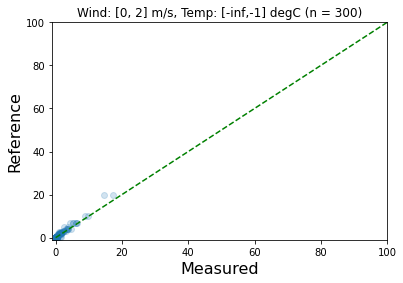

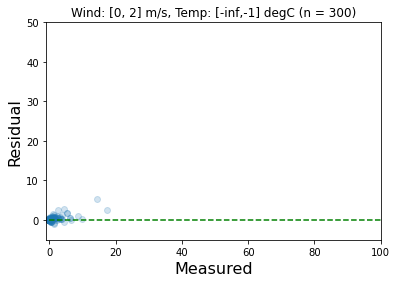

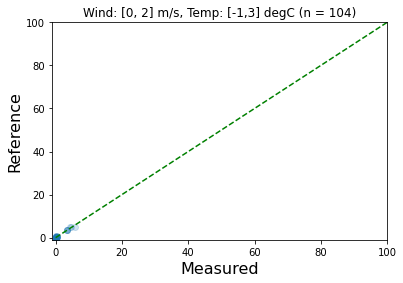

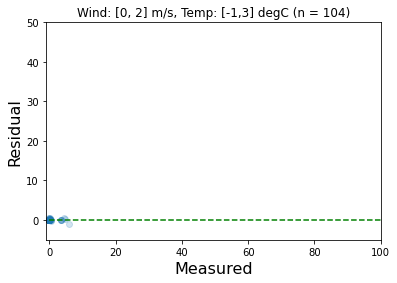

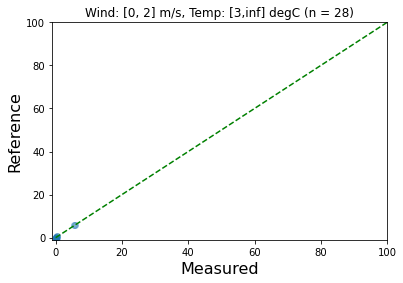

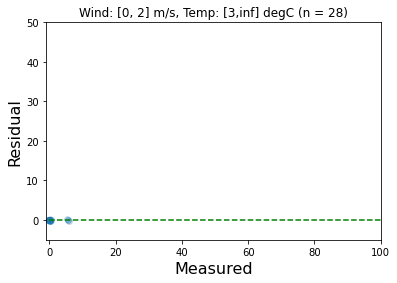

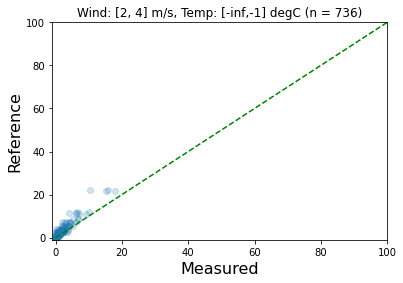

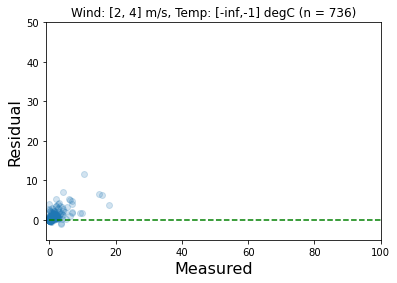

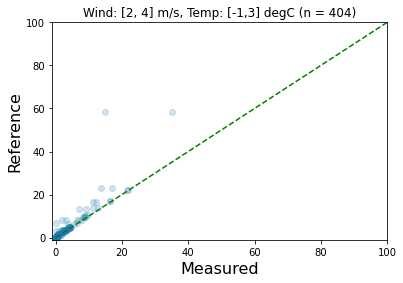

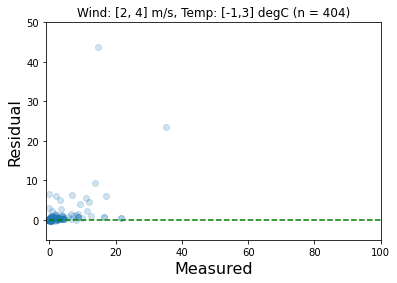

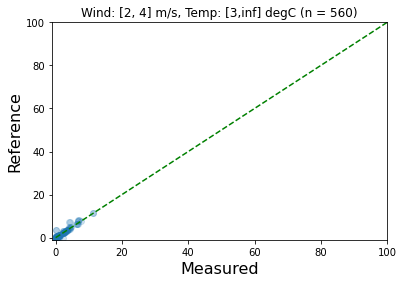

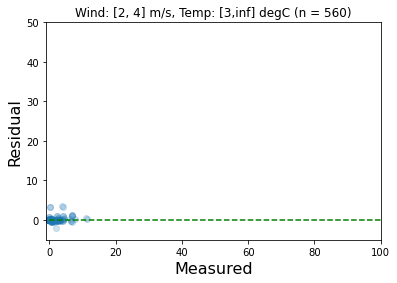

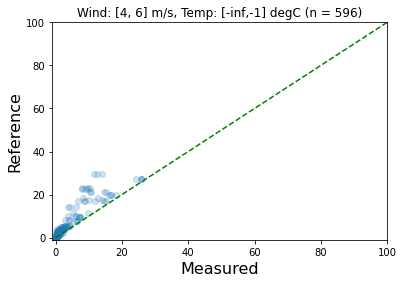

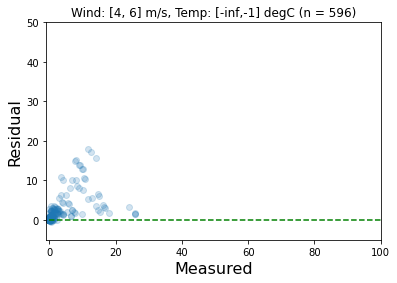

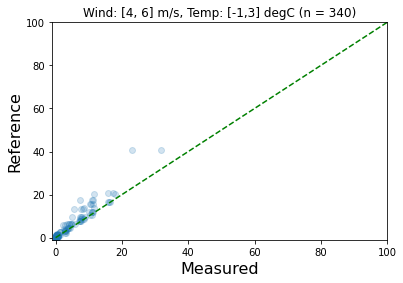

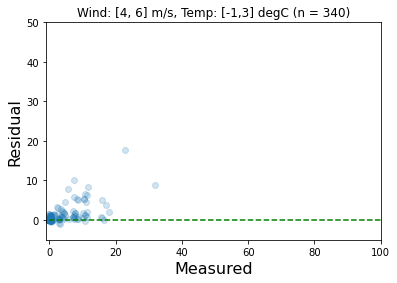

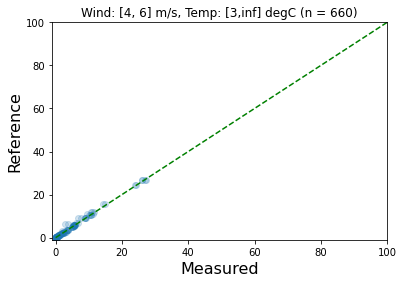

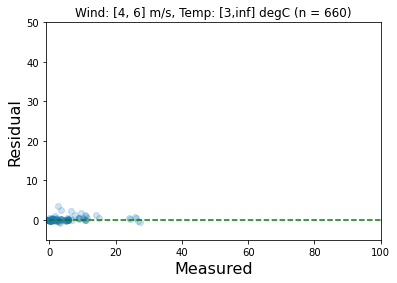

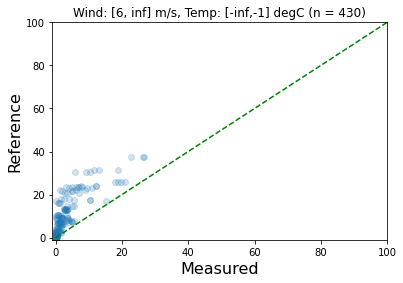

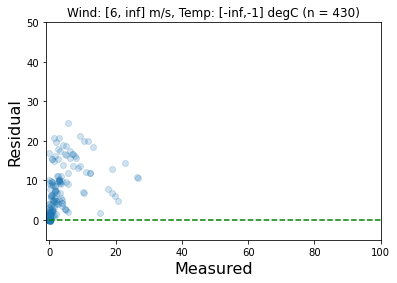

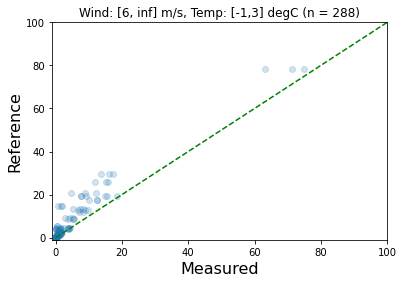

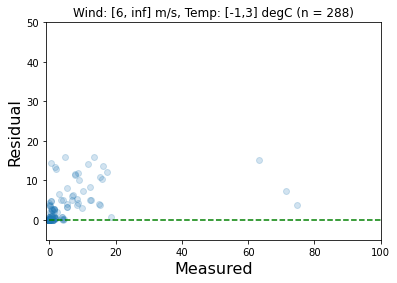

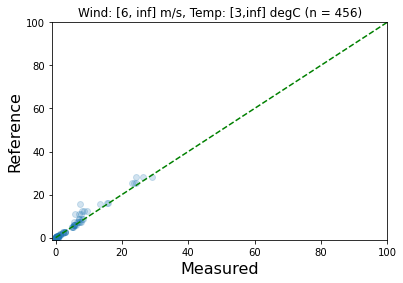

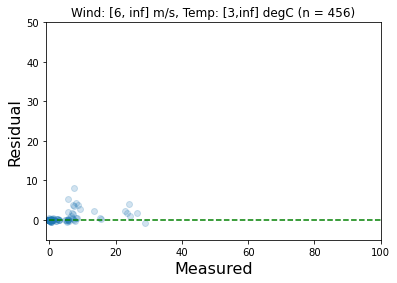

In [16]:
x = np.linspace(0,100,101)

wind_bounds = [0,2,4,6,np.inf]
temp_bounds = [-np.inf,-1,3,np.inf]
for (wind_lb, wind_ub) in zip(wind_bounds[:-1],wind_bounds[1:]):
    for (temp_lb, temp_ub) in zip(temp_bounds[:-1],temp_bounds[1:]):
        # data selection
        data_selected = data_daily_long.loc[(data_daily_long['Air Temperature [degC]']<temp_ub)&
                                            (data_daily_long['Air Temperature [degC]']>=temp_lb)&
                                            #(data_daily_long['Measured Precipitation [mm]']>0)&
                                            #(data_daily_long['Reference Precipitation [mm]']>0)&
                                            (~data_daily_long['Outliers'])&
                                            (data_daily_long['Wind Speed [m/s]']<wind_ub)&
                                            (data_daily_long['Wind Speed [m/s]']>=wind_lb)]
        data_selected = data_selected.rename(columns={'Measured Precipitation [mm]':'measured',
                                      'Reference Precipitation [mm]':'reference'})
        data_selected['residual'] = data_selected['reference'] - data_selected['measured']
        # Fig. 1
        fig1 = plt.figure()
        ax = plt.gca()
        ax.scatter(data_selected.measured, data_selected.reference, alpha=0.2)
        ax.set_xlim((-1, 100))
        ax.set_ylim((-1, 100))
        ax.set_xlabel("Measured", fontsize=16)
        ax.set_ylabel("Reference", fontsize=16)
        ax.plot(x, x, color="green", linestyle='--')
        #legend = ax.legend()
        plt.title(f"Wind: [{wind_lb}, {wind_ub}] m/s, Temp: [{temp_lb},{temp_ub}] degC (n = {len(data_selected)})")
        # Fig. 2
        fig2 = plt.figure()
        ax = plt.gca()
        ax.scatter(data_selected.measured, data_selected.residual, alpha=0.2)
        ax.set_xlim((-1, 100))
        ax.set_ylim((-5, 50))
        ax.set_xlabel("Measured", fontsize=16)
        ax.set_ylabel("Residual", fontsize=16)
        ax.plot(x, np.zeros(x.shape), color="green", linestyle='--')
        #legend = ax.legend()
        plt.title(f"Wind: [{wind_lb}, {wind_ub}] m/s, Temp: [{temp_lb},{temp_ub}] degC (n = {len(data_selected)})")

### Fitting functions

In [17]:
def linear_fit(data, x_name='x', y_name='y'):
    X = data[[x_name]]
    Y = data[[y_name]]
    X = sm.add_constant(X)
    model = sm.OLS(Y,X)
    results = model.fit()
    params_df = results.conf_int()
    params_df = results.conf_int().rename(columns={0:'lb', 1:'ub'})
    params_df['params'] = results.params
    params_df = params_df.rename(index={'const':'b',x_name:'a'})
    return params_df

def linear_eval(x, params_dict):
    return params_dict['a']*x + params_dict['b']

def multiplicative_fit(data, x_name, y_name): # y ~ a*x
    X = data[[x_name]]
    Y = data[[y_name]]
    model = sm.OLS(Y,X)
    results = model.fit()
    params_df = results.conf_int()
    params_df = results.conf_int().rename(columns={0:'lb', 1:'ub'})
    params_df['params'] = results.params
    params_df = params_df.rename(index={x_name:'a'})
    return params_df

def multiplicative_eval(x, params_dict):
    return params_dict['a']*x

def powerlaw_fit(data, x_name='x', y_name='y'):
    # Remove any zero values before taking log
    data = data.loc[(data[x_name]>0)&(data[y_name]>0)]
    X = np.log(data[[x_name]])
    Y = np.log(data[[y_name]])
    X = sm.add_constant(X)
    model = sm.OLS(Y,X)
    results = model.fit()
    results.params['const'] = np.exp(results.params['const'])
    params_df = results.conf_int()
    params_df = results.conf_int().rename(columns={0:'lb', 1:'ub'})
    params_df['params'] = results.params
    params_df = params_df.rename(index={'const':'c',x_name:'d'})
    return params_df

def check_powerlaw(params):
    if (params.at['d', 'params']<0) or (params.at['d', 'params']>1) or (params.at['c', 'params']<0): # decreasing or convex fitting function 
        params.at['c', 'params'] = 0
        params.at['d', 'params'] = 1 # i.e. don't do any power law fit
        params.at['c', 'lb'] = np.nan
        params.at['c', 'ub'] = np.nan
        params.at['d', 'lb'] = np.nan
        params.at['d', 'ub'] = np.nan
    return params

def check_linear(params):
    if (params.at['b', 'params']<0): # decreasing or convex fitting function 
        params.at['b', 'params'] = 0
        params.at['b', 'lb'] = np.nan
        params.at['b', 'ub'] = np.nan
    if (params.at['a', 'params']<0): # decreasing or convex fitting function 
        params.at['a', 'params'] = 0
        params.at['a', 'lb'] = np.nan
        params.at['a', 'ub'] = np.nan
    return params

def powerlaw_eval(x, params_dict):
    return params_dict['c']*x**params_dict['d']

def eval_corrected(x, params):
    return x+powerlaw_eval(x, params[['c','d']])#+linear_eval(x, params[['a','b']])

### Fitting loop

In [134]:
def generate_fig_a(data_selected, x, correction, lb, ub):
    fig = plt.figure(figsize=(8,8))
    ax = plt.gca()
    ax2 = main_fig_a(ax, data_selected, x, correction, lb, ub)
    axins = ax2.inset_axes([0.6, 0.1, 0.3, 0.3])
    inset_fig_a(axins, data_selected, x, correction, lb, ub)
    ax.legend(fontsize=20, loc=2)
    return fig

In [135]:
def main_fig_a(ax, data_selected, x, correction, lb, ub):
    #fig = plt.figure()
    #ax = plt.gca()
    ax.scatter(data_selected.measured, data_selected.reference, alpha=0.2, label='Observations')
    ax.plot(x, correction, color='grey', label='Correction', linewidth=2)
    ax.plot(x, ub, ':', color='dimgrey', label='95% c.i.', linewidth=2)
    ax.plot(x, lb, ':', color='dimgrey', linewidth=2)            
    ax.set_xlim((-5, 100))
    ax.set_ylim((-5, 100))
    ax.set_xlabel("Measured Precip. [mm]", fontsize=32)
    ax.set_ylabel("Reference Precip. [mm]", fontsize=32)
    ax.plot(x, x, color="green", linestyle='--', linewidth=2)
    ax.grid()
    ax.xaxis.set_tick_params(labelsize=16)
    ax.yaxis.set_tick_params(labelsize=16)
    return ax

In [136]:
def inset_fig_a(ax, data_selected, x, correction, lb, ub):
    ax.scatter(data_selected.measured, data_selected.reference, alpha=0.2)
    ax.plot(x, correction, color='grey')
    ax.plot(x, ub, ':', color='dimgrey')
    ax.plot(x, lb, ':', color='dimgrey')            
    ax.set_xlim((-0.1, 5))
    ax.set_ylim((-0.1, 5))
    ax.set_xticks([0,1,2,3,4,5])
    ax.set_yticks([0,1,2,3,4,5])
    ax.plot(x, x, color="grey", linestyle='--')
    ax.xaxis.set_tick_params(labelsize=16)
    ax.yaxis.set_tick_params(labelsize=16)
    return ax

In [137]:
def generate_fig_b(data_selected, x, correction, lb, ub):
    fig = plt.figure(figsize=(8,8))
    ax = plt.gca()
    ax.scatter(data_selected.corrected, data_selected['log-error'], alpha=0.2, label='Observations')
    ax.set_xlim((0.05, 100))
    ax.set_ylim((-4, 4))
    ax.set_xlabel("Corrected Precip. [mm]", fontsize=32)
    ax.set_ylabel("Residual log error", fontsize=32)
    ax.semilogx(x, log_error_bound, ':', color='dimgrey', linewidth=2, label='95% c.i.')
    ax.semilogx(x, -log_error_bound, ':', color='dimgrey', linewidth=2)
    ax.semilogx(x, np.zeros(x.shape), color="grey", linestyle='--', linewidth=2)
    ax.xaxis.set_tick_params(labelsize=16)
    ax.yaxis.set_tick_params(labelsize=16)
    return fig#, legend

Wind: [0, 3] m/s, Temp: [-inf,-1] degC (n = 164)
         lb        ub    params
c  0.143234  0.709367  0.426300
d  0.528280  0.934804  0.731542
Wind: [0, 3] m/s, Temp: [-inf,-1] degC (n = 164)


C:\Users\brunetd\AppData\Local\Temp\ipykernel_27904\366246653.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  params = params_cat.append(params_fit).append(params_error_small).append(params_error_large)
C:\Users\brunetd\AppData\Local\Temp\ipykernel_27904\366246653.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  params = params_cat.append(params_fit).append(params_error_small).append(params_error_large)
C:\Users\brunetd\AppData\Local\Temp\ipykernel_27904\366246653.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  params = params_cat.append(params_fit).append(params_error_small).append(params_error_large)
C:\Users\brunetd\AppData\Local\Temp\ipykernel_27904\366246653.py:64: RuntimeWarning: invalid value encountere

Wind: [3, 6] m/s, Temp: [-inf,-1] degC (n = 296)
         lb        ub    params
c  0.625585  0.969036  0.797311
d  0.616243  0.835264  0.725754
Wind: [3, 6] m/s, Temp: [-inf,-1] degC (n = 296)


C:\Users\brunetd\AppData\Local\Temp\ipykernel_27904\366246653.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  params = params_cat.append(params_fit).append(params_error_small).append(params_error_large)
C:\Users\brunetd\AppData\Local\Temp\ipykernel_27904\366246653.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  params = params_cat.append(params_fit).append(params_error_small).append(params_error_large)
C:\Users\brunetd\AppData\Local\Temp\ipykernel_27904\366246653.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  params = params_cat.append(params_fit).append(params_error_small).append(params_error_large)
C:\Users\brunetd\AppData\Local\Temp\ipykernel_27904\366246653.py:64: RuntimeWarning: invalid value encountere

Wind: [6, inf] m/s, Temp: [-inf,-1] degC (n = 158)
         lb        ub    params
c  2.628391  3.327488  2.977939
d  0.481800  0.917287  0.699543
Wind: [6, inf] m/s, Temp: [-inf,-1] degC (n = 158)


C:\Users\brunetd\AppData\Local\Temp\ipykernel_27904\366246653.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  params = params_cat.append(params_fit).append(params_error_small).append(params_error_large)
C:\Users\brunetd\AppData\Local\Temp\ipykernel_27904\366246653.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  params = params_cat.append(params_fit).append(params_error_small).append(params_error_large)
C:\Users\brunetd\AppData\Local\Temp\ipykernel_27904\366246653.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  params = params_cat.append(params_fit).append(params_error_small).append(params_error_large)
C:\Users\brunetd\AppData\Local\Temp\ipykernel_27904\366246653.py:64: RuntimeWarning: invalid value encountere

Wind: [0, 3] m/s, Temp: [-1,3] degC (n = 61)
         lb        ub    params
c -0.184582  0.857728  0.336573
d -0.061445  0.607787  0.273171
Wind: [0, 3] m/s, Temp: [-1,3] degC (n = 61)


C:\Users\brunetd\AppData\Local\Temp\ipykernel_27904\366246653.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  params = params_cat.append(params_fit).append(params_error_small).append(params_error_large)
C:\Users\brunetd\AppData\Local\Temp\ipykernel_27904\366246653.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  params = params_cat.append(params_fit).append(params_error_small).append(params_error_large)
C:\Users\brunetd\AppData\Local\Temp\ipykernel_27904\366246653.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  params = params_cat.append(params_fit).append(params_error_small).append(params_error_large)
C:\Users\brunetd\AppData\Local\Temp\ipykernel_27904\366246653.py:64: RuntimeWarning: invalid value encountere

Wind: [3, 6] m/s, Temp: [-1,3] degC (n = 185)
         lb        ub    params
c  0.194191  0.750318  0.472255
d  0.368064  0.692481  0.530272
Wind: [3, 6] m/s, Temp: [-1,3] degC (n = 185)


C:\Users\brunetd\AppData\Local\Temp\ipykernel_27904\366246653.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  params = params_cat.append(params_fit).append(params_error_small).append(params_error_large)
C:\Users\brunetd\AppData\Local\Temp\ipykernel_27904\366246653.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  params = params_cat.append(params_fit).append(params_error_small).append(params_error_large)
C:\Users\brunetd\AppData\Local\Temp\ipykernel_27904\366246653.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  params = params_cat.append(params_fit).append(params_error_small).append(params_error_large)
C:\Users\brunetd\AppData\Local\Temp\ipykernel_27904\366246653.py:64: RuntimeWarning: invalid value encountere

Wind: [6, inf] m/s, Temp: [-1,3] degC (n = 96)
         lb        ub    params
c  0.673872  1.498158  1.086015
d  0.390590  0.852723  0.621656
Wind: [6, inf] m/s, Temp: [-1,3] degC (n = 96)


C:\Users\brunetd\AppData\Local\Temp\ipykernel_27904\366246653.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  params = params_cat.append(params_fit).append(params_error_small).append(params_error_large)
C:\Users\brunetd\AppData\Local\Temp\ipykernel_27904\366246653.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  params = params_cat.append(params_fit).append(params_error_small).append(params_error_large)
C:\Users\brunetd\AppData\Local\Temp\ipykernel_27904\366246653.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  params = params_cat.append(params_fit).append(params_error_small).append(params_error_large)
C:\Users\brunetd\AppData\Local\Temp\ipykernel_27904\366246653.py:64: RuntimeWarning: invalid value encountere

Wind: [0, 3] m/s, Temp: [3,inf] degC (n = 47)
         lb        ub    params
c -0.993636  1.193450  0.099907
d -0.544234  0.962081  0.208924
Wind: [0, 3] m/s, Temp: [3,inf] degC (n = 47)


C:\Users\brunetd\AppData\Local\Temp\ipykernel_27904\366246653.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  params = params_cat.append(params_fit).append(params_error_small).append(params_error_large)
C:\Users\brunetd\AppData\Local\Temp\ipykernel_27904\366246653.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  params = params_cat.append(params_fit).append(params_error_small).append(params_error_large)
C:\Users\brunetd\AppData\Local\Temp\ipykernel_27904\366246653.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  params = params_cat.append(params_fit).append(params_error_small).append(params_error_large)
C:\Users\brunetd\AppData\Local\Temp\ipykernel_27904\366246653.py:64: RuntimeWarning: invalid value encountere

Wind: [3, 6] m/s, Temp: [3,inf] degC (n = 161)
   lb  ub  params
c NaN NaN     0.0
d NaN NaN     1.0
Wind: [3, 6] m/s, Temp: [3,inf] degC (n = 161)


C:\Users\brunetd\AppData\Local\Temp\ipykernel_27904\366246653.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  params = params_cat.append(params_fit).append(params_error_small).append(params_error_large)
C:\Users\brunetd\AppData\Local\Temp\ipykernel_27904\366246653.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  params = params_cat.append(params_fit).append(params_error_small).append(params_error_large)
C:\Users\brunetd\AppData\Local\Temp\ipykernel_27904\366246653.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  params = params_cat.append(params_fit).append(params_error_small).append(params_error_large)
C:\Users\brunetd\AppData\Local\Temp\ipykernel_27904\366246653.py:64: RuntimeWarning: invalid value encountere

Wind: [6, inf] m/s, Temp: [3,inf] degC (n = 71)
         lb        ub    params
c -0.848323  1.123102  0.137390
d  0.208816  1.300271  0.754543
Wind: [6, inf] m/s, Temp: [3,inf] degC (n = 71)


C:\Users\brunetd\AppData\Local\Temp\ipykernel_27904\366246653.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  params = params_cat.append(params_fit).append(params_error_small).append(params_error_large)
C:\Users\brunetd\AppData\Local\Temp\ipykernel_27904\366246653.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  params = params_cat.append(params_fit).append(params_error_small).append(params_error_large)
C:\Users\brunetd\AppData\Local\Temp\ipykernel_27904\366246653.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  params = params_cat.append(params_fit).append(params_error_small).append(params_error_large)
C:\Users\brunetd\AppData\Local\Temp\ipykernel_27904\366246653.py:64: RuntimeWarning: invalid value encountere

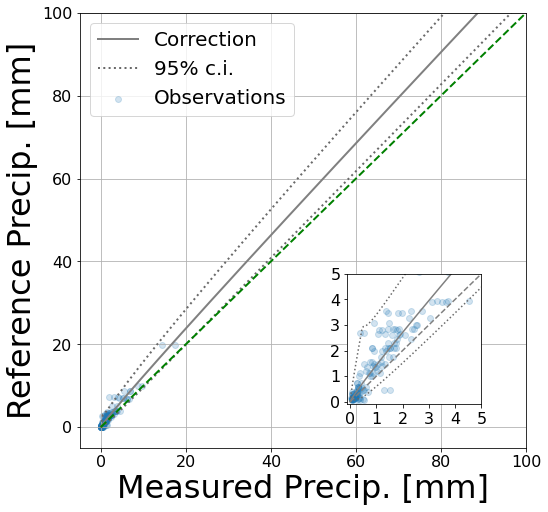

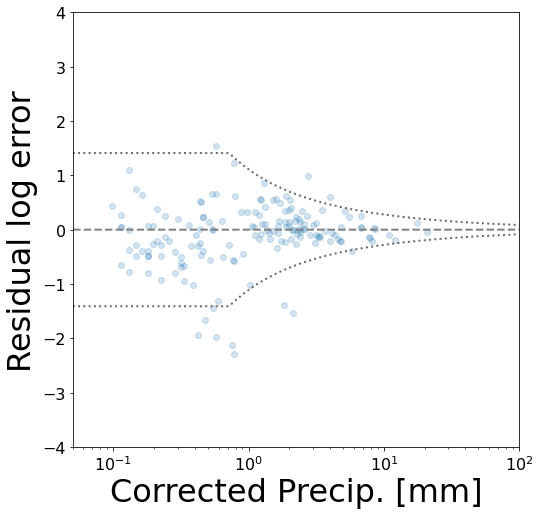

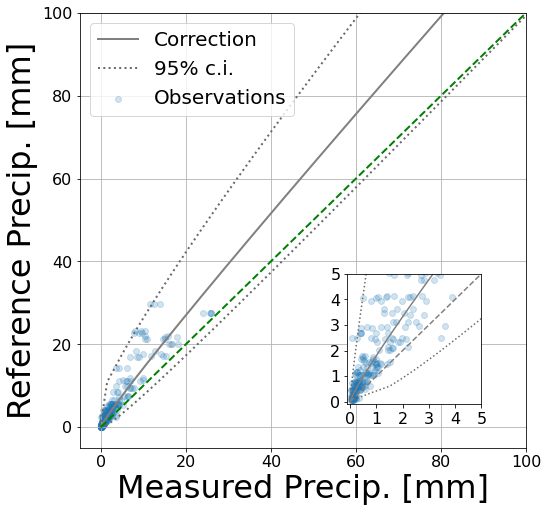

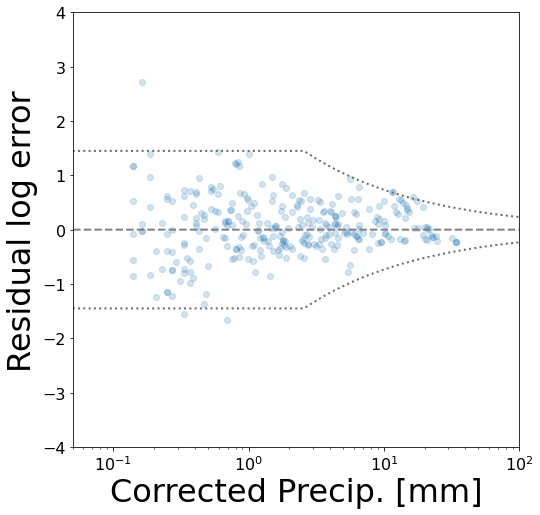

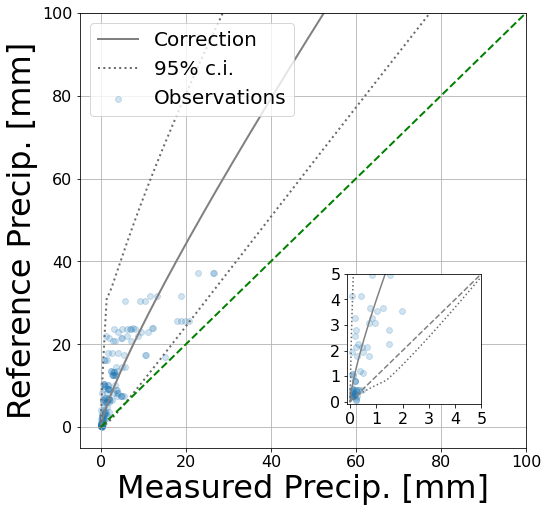

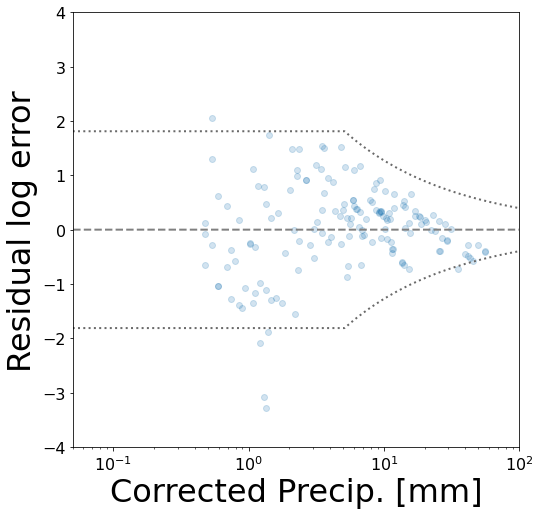

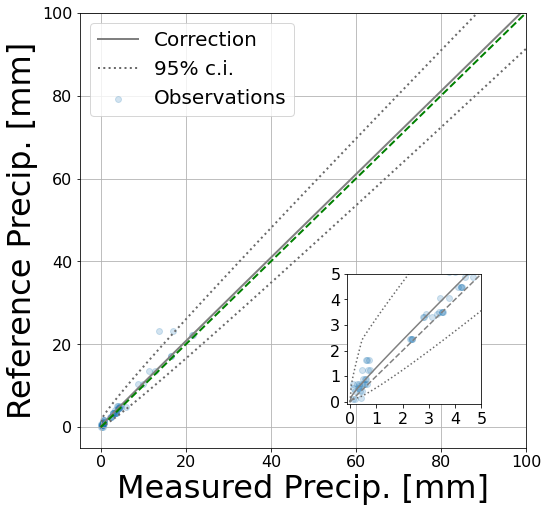

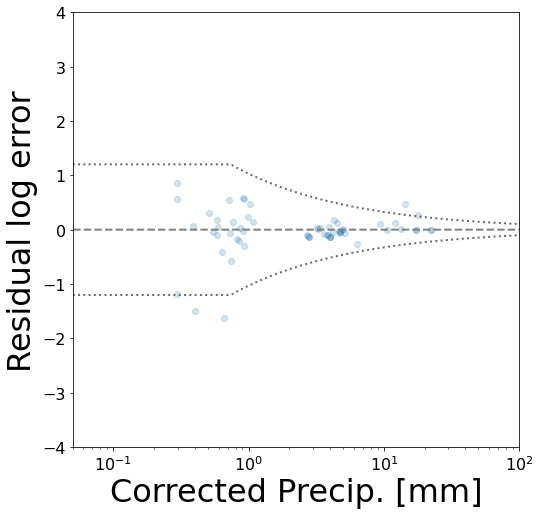

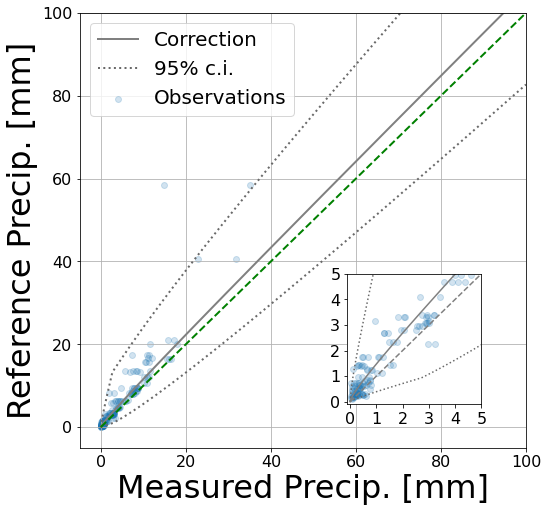

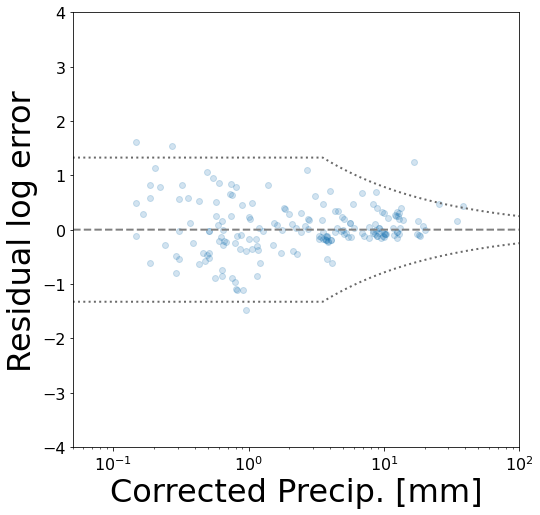

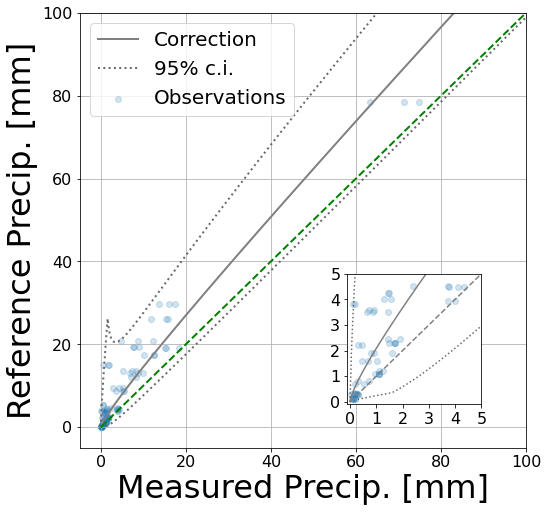

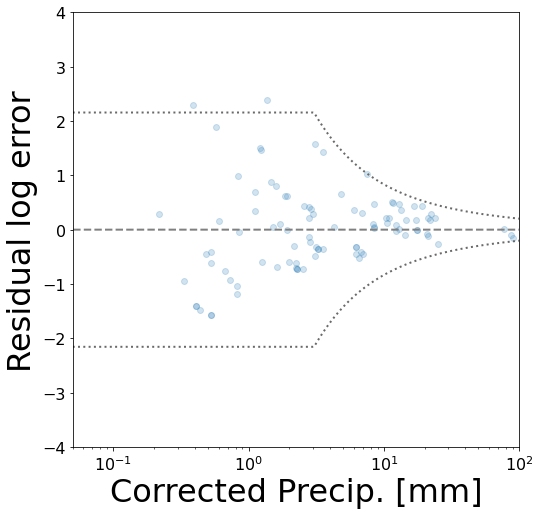

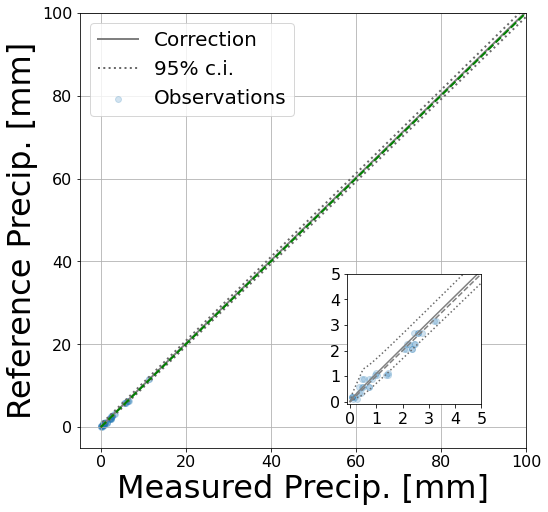

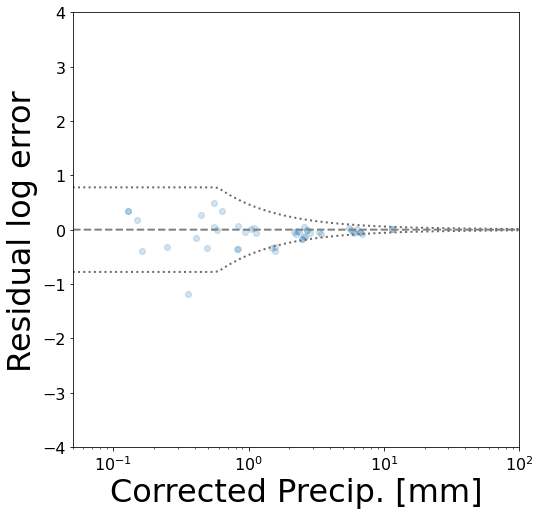

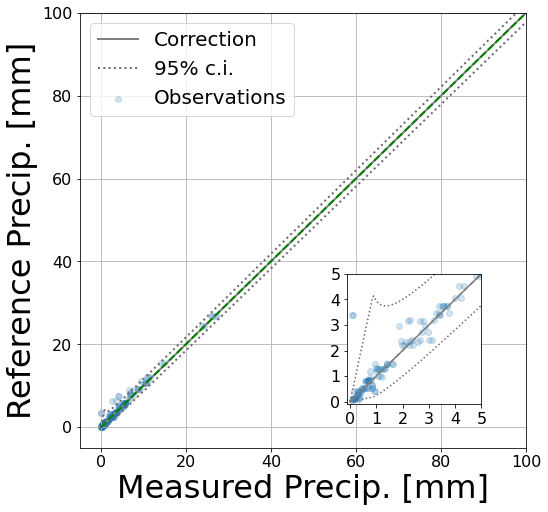

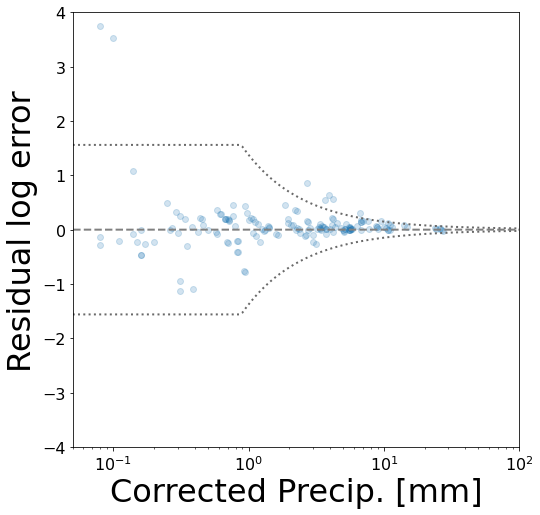

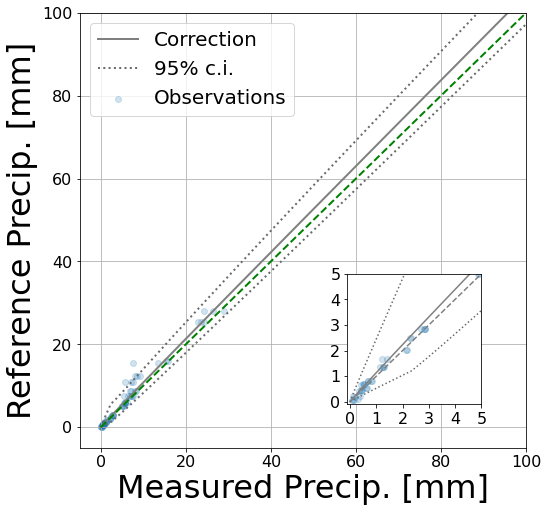

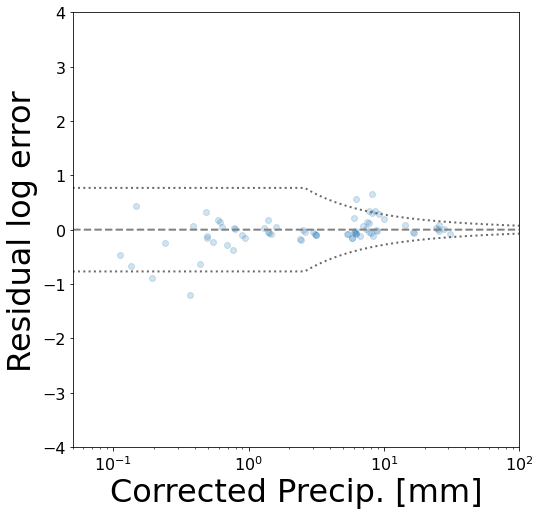

In [138]:
wind_dict = {0:'low', 3:'medium', 6:'high'}
phase_dict = {-np.inf:'snow', -1:'mixed', 3:'rain'}

params_all = []
x = np.linspace(0,100,2001)
wind_bounds = [0,3,6,np.inf]#
temp_bounds = [-np.inf, -1, 3, np.inf]
for (temp_lb, temp_ub) in zip(temp_bounds[:-1],temp_bounds[1:]):
    for (wind_lb, wind_ub) in zip(wind_bounds[:-1],wind_bounds[1:]):
        
        params_cat = pd.DataFrame(index=['wind speed','phase'], data={'lb':[np.nan,np.nan], 
                                                                      'ub':[np.nan,np.nan], 
                                                                      'params':[wind_dict[wind_lb], 
                                                                                phase_dict[temp_lb]]})
        data_selected = data_daily_long.loc[(data_daily_long['Air Temperature [degC]']<temp_ub)&
                                (data_daily_long['Air Temperature [degC]']>=temp_lb)&
                                (data_daily_long['Measured Precipitation [mm]']>0)&
                                (data_daily_long['Reference Precipitation [mm]']>0)&
                                (~data_daily_long['Outliers'])&
                                (data_daily_long['Wind Speed [m/s]']<wind_ub)&
                                (data_daily_long['Wind Speed [m/s]']>=wind_lb)]
        data_selected = data_selected.rename(columns={'Measured Precipitation [mm]':'measured',
                                  'Reference Precipitation [mm]':'reference'})

        N = len(data_selected)
        if N<30:
            print('Warning: small N')
        print(f"Wind: [{wind_lb}, {wind_ub}] m/s, Temp: [{temp_lb},{temp_ub}] degC (n = {N})")
        # Power law fit on reference - measured
        data_selected['residual'] = data_selected['reference'] - data_selected['measured']
        params_fit = powerlaw_fit(data_selected, 'measured', 'residual')
        params_fit = check_powerlaw(params_fit)

        print(params_fit)
        data_selected['corrected'] = eval_corrected(data_selected['measured'], params_fit['params'])

        # MSE params estimation (for large values)
        data_selected['error_residual'] = data_selected['reference'] - data_selected['corrected']
        data_selected['square_residual'] = data_selected['error_residual']**2
        perc_out = 0.99 # approximate percentage not-outliers
        perc_ci = 0.95
        data_selected_small_error = data_selected.sort_values(by='square_residual').iloc[0:int(perc_out*N)] # keep ~99% of data
        N_kept = len(data_selected_small_error)
        perc_kept = N_kept/N # exact percentage data kept
        perc_bound = perc_ci/perc_kept # needed percentage in c.i.
        ci_int = ss.norm.ppf((perc_bound+1)/2)
        #params_mse = linear_fit(data_selected_small_error, 'measured', 'square_residual')
        params_error_large = linear_fit(data_selected_small_error, 'corrected', 'square_residual')
        params_error_large = check_linear(params_error_large)
        # RMSE bounds
        error_bound_large = ci_int*np.sqrt(linear_eval(x, params_error_large['params']))
        correction = eval_corrected(x, params_fit['params'])
        data_selected['log-error'] = np.log(data_selected['reference']) - np.log(data_selected['corrected'])
        data_selected_small = data_selected.loc[data_selected['corrected']<=1]
        gamma = np.std(data_selected_small['log-error'])
        params_error_small = pd.DataFrame(index=['gamma'], data={'lb':np.nan, 'ub':np.nan, 'params':gamma})
        
        params = params_cat.append(params_fit).append(params_error_small).append(params_error_large)
        params_all.append(params['params'])
        
        error_bound_small = 1.96*np.ones(len(x))*gamma*x
        error_bound = np.minimum(error_bound_small, error_bound_large)

        log_error_bound = error_bound/x
        
        def compute_error(M):
            C = eval_corrected(M, params_fit['params'])
            S = np.std(data_selected_small['log-error'])
            error_bound_small = 1.96*np.ones(len(M))*S*C
            error_bound_large = ci_int*np.sqrt(linear_eval(C, params_error_large['params']))
            error_bound = np.minimum(error_bound_small, error_bound_large)
            log_error_bound = error_bound/C
            error_ub = C*np.exp(log_error_bound)
            error_lb = C*np.exp(-log_error_bound)
            error_ub[np.isnan(error_ub)] = 0
            error_lb[np.isnan(error_lb)] = 0
            return error_lb, error_ub
            
        # Fig. 1
        print(f"Wind: [{wind_lb}, {wind_ub}] m/s, Temp: [{temp_lb},{temp_ub}] degC (n = {len(data_selected)})")
        lb, ub = compute_error(x)
        fig1a = generate_fig_a(data_selected, x, correction, lb, ub) ### -> missing function!!!
        #plt.title(f"Wind: [{wind_lb}, {wind_ub}] m/s, Temp: [{temp_lb},{temp_ub}] degC (n = {len(data_selected)})")
        fig1a.savefig(os.path.join(FIG, f"FigAa-{phase_dict[temp_lb]}-{wind_dict[wind_lb]}.png"), bbox_inches='tight')
        

        fig1b = generate_fig_b(data_selected, x, correction, lb, ub)
        #plt.title(f"Wind: [{wind_lb}, {wind_ub}] m/s, Temp: [{temp_lb},{temp_ub}] degC (n = {len(data_selected)})")
        fig1b.savefig(os.path.join(FIG, f"FigAb-{phase_dict[temp_lb]}-{wind_dict[wind_lb]}.png"), bbox_inches='tight')

In [72]:
ax.legend()
plt.show()

No handles with labels found to put in legend.


In [23]:
params_all = pd.DataFrame(params_all).rename(columns={'a':'alpha','b':'beta','c':'a','d':'b'})
params_all
params_all.reset_index().to_csv('RESULTS/fitting_parameters.csv')

In [24]:
pd.read_csv('RESULTS/fitting_parameters.csv',index_col=0)

index wind speed  phase         a         b     gamma      beta     alpha
0  params        low   snow  0.426300  0.731542  0.718868  0.116682  0.169636
1  params     medium   snow  0.797311  0.725754  0.739195  0.000000  1.280132
2  params       high   snow  2.977939  0.699543  0.923639  1.326137  3.632238
3  params        low  mixed  0.336573  0.273171  0.612959  0.000000  0.236438
4  params     medium  mixed  0.472255  0.530272  0.676511  0.000000  1.466541
5  params       high  mixed  1.086015  0.621656  1.099475  7.472747  0.900640
6  params        low   rain  0.099907  0.208924  0.396861  0.042857  0.002730
7  params     medium   rain  0.000000  1.000000  0.795479  0.431173  0.007507
8  params       high   rain  0.137390  0.754543  0.392156  0.611359  0.115294

# POP

In [25]:
precip_dict = {0:'none', 0.2:'trace', 3:'low', np.inf:'medium-heavy'}

k = 0 
params_all = []
wind_bounds = [0,3,6,np.inf]
temp_bounds = [-np.inf,-1,3,np.inf]
precip_bounds = [-np.inf,0,0.2,3,np.inf]
for (temp_lb, temp_ub) in zip(temp_bounds[:-1],temp_bounds[1:]):
    for (wind_lb, wind_ub) in zip(wind_bounds[:-1],wind_bounds[1:]):
        for (precip_lb, precip_ub) in zip(precip_bounds[:-1],precip_bounds[1:]):
            params_select = dict()
            # data selection
            data_selected = data_daily_long.loc[(data_daily_long['Air Temperature [degC]']<temp_ub)&
                                          (data_daily_long['Air Temperature [degC]']>=temp_lb)&
                                          (data_daily_long['Measured Precipitation [mm]']>precip_lb)&
                                          (data_daily_long['Measured Precipitation [mm]']<=precip_ub)&
                                          (~data_daily_long['Outliers'])&
                                          (data_daily_long['Wind Speed [m/s]']<wind_ub)&
                                          (data_daily_long['Wind Speed [m/s]']>=wind_lb)]
            n = len(data_selected.loc[data_selected['Reference Precipitation [mm]']==0])
            N = len(data_selected)
            params_select['wind speed'] = wind_dict[wind_lb] 
            params_select['phase'] = phase_dict[temp_lb]
            params_select['precip'] = precip_dict[precip_ub] 
            params_select['N'] = len(data_selected)
            if N<25:
                print(f"-- Small sample warning -- ")
            params_select['PoP'] = 1-n/N
            mu_A = np.log(data_selected.loc[data_selected['Reference Precipitation [mm]']>0, 
                                            'Reference Precipitation [mm]']).mean()
            params_select['mu_A'] = mu_A
            sigma_A = np.log(data_selected.loc[data_selected['Reference Precipitation [mm]']>0, 
                                            'Reference Precipitation [mm]']).std()
            params_select['sigma_A'] = sigma_A
            print(f"PoP = {params_select['PoP']} (E[log(P)] = {params_select['mu_A']}, V[log(P)] = {params_select['sigma_A']**2}) for {params_select['wind speed']} wind speed, {params_select['phase']} precip phase, {params_select['precip']} precip amount (N = {N})")
            params_select = pd.DataFrame(index=[k], data=params_select)
            if len(params_all)==0:
                params_all = params_select
            else:
                params_all = params_all.append(params_select)
            k = k+1



C:\Users\brunetd\AppData\Local\Temp\ipykernel_27904\2012427536.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  params_all = params_all.append(params_select)
C:\Users\brunetd\AppData\Local\Temp\ipykernel_27904\2012427536.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  params_all = params_all.append(params_select)
C:\Users\brunetd\AppData\Local\Temp\ipykernel_27904\2012427536.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  params_all = params_all.append(params_select)
C:\Users\brunetd\AppData\Local\Temp\ipykernel_27904\2012427536.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  params_all = params_all.append(params_sele

PoP = 0.3374485596707819 (E[log(P)] = -2.063040424749593, V[log(P)] = 0.4329182495273048) for low wind speed, snow precip phase, none precip amount (N = 243)
PoP = 0.6607142857142857 (E[log(P)] = -1.879717591829787, V[log(P)] = 0.21823680613539953) for low wind speed, snow precip phase, trace precip amount (N = 56)
PoP = 0.9122807017543859 (E[log(P)] = 0.14132200578745857, V[log(P)] = 1.0818541539384319) for low wind speed, snow precip phase, low precip amount (N = 114)
-- Small sample warning -- 
PoP = 1.0 (E[log(P)] = 1.8935453986036475, V[log(P)] = 0.23788290166701972) for low wind speed, snow precip phase, medium-heavy precip amount (N = 23)
PoP = 0.2981927710843374 (E[log(P)] = -1.5390759384328077, V[log(P)] = 0.7832889287791348) for medium wind speed, snow precip phase, none precip amount (N = 332)
PoP = 0.717948717948718 (E[log(P)] = -1.38856510853775, V[log(P)] = 0.6770471726427832) for medium wind speed, snow precip phase, trace precip amount (N = 78)
PoP = 0.9759036144578314 

C:\Users\brunetd\AppData\Local\Temp\ipykernel_27904\2012427536.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  params_all = params_all.append(params_select)
C:\Users\brunetd\AppData\Local\Temp\ipykernel_27904\2012427536.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  params_all = params_all.append(params_select)
C:\Users\brunetd\AppData\Local\Temp\ipykernel_27904\2012427536.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  params_all = params_all.append(params_select)
C:\Users\brunetd\AppData\Local\Temp\ipykernel_27904\2012427536.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  params_all = params_all.append(params_sele

In [26]:
params_low = params_all.loc[params_all['precip']!='medium-heavy']
np.exp(params_low['mu_A'])

0     0.127067
1     0.152633
2     1.151795
4     0.214579
5     0.249433
6     1.676060
8     0.471922
9     0.576114
10    4.160944
12    0.146710
13    0.261407
14    1.043779
16    0.330693
17    0.326863
18    1.122119
20    0.315075
21    0.297952
22    2.111439
24    0.110000
25    0.163116
26    1.110357
28    0.133601
29    0.201780
30    0.949500
32    0.122146
33    0.111366
34    0.965176
Name: mu_A, dtype: float64

In [27]:
N = params_all.loc[params_all['precip']=='medium-heavy'].sum()['N']

In [28]:
p = params_all.loc[params_all['precip']=='medium-heavy'].mean()['PoP']

C:\Users\brunetd\AppData\Local\Temp\ipykernel_27904\2623681290.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  p = params_all.loc[params_all['precip']=='medium-heavy'].mean()['PoP']


In [29]:
p_prime = (p*N+99)/(N+100)

In [30]:
params_heavy = pd.DataFrame(index=[26], data={'wind speed':'*', 'phase':'*', 'precip':'medium-heavy','N':N,'PoP':p_prime})

In [31]:
params_all = params_heavy.append(params_low)

C:\Users\brunetd\AppData\Local\Temp\ipykernel_27904\1172633245.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  params_all = params_heavy.append(params_low)


In [32]:
def compute_pop_unc(p, N):
    return np.sqrt(p*(1-p)/N)

In [33]:
params_all['PoP unc.'] = compute_pop_unc(params_all['PoP'],params_all['N'])

In [34]:
params_all['PoP lb'] = params_all['PoP'] - params_all['PoP unc.']
params_all['PoP ub'] = np.minimum(1, params_all['PoP'] + params_all['PoP unc.'])

In [35]:
import numpy as np

In [36]:
{'low-snow':np.exp(-2.063040),'med-snow':np.exp(-1.539076),'high-snow':np.exp(-0.750941),
'low-mixed':np.exp(-1.919297),'med-mixed':np.exp(-1.106565),'high-mixed':np.exp(-1.154946),
'low-rain':np.exp(-2.207275),'med-rain':np.exp(-2.012895),'high-rain':np.exp(-2.102535)}

{'low-snow': 0.12706709816930603,
 'med-snow': 0.21457928110960975,
 'high-snow': 0.4719222648851057,
 'low-mixed': 0.14671006306045858,
 'med-mixed': 0.33069294260475096,
 'high-mixed': 0.3150745504697683,
 'low-rain': 0.1099999904508697,
 'med-rain': 0.1336013383954174,
 'high-rain': 0.12214639434137252}

In [37]:
params_all['exp(mu_A)'] = np.exp(params_all['mu_A'])
params_all

wind speed  phase        precip    N       PoP      mu_A   sigma_A  \
26          *      *  medium-heavy  421  0.998081       NaN       NaN   
0         low   snow          none  243  0.337449 -2.063040  0.657965   
1         low   snow         trace   56  0.660714 -1.879718  0.467158   
2         low   snow           low  114  0.912281  0.141322  1.040122   
4      medium   snow          none  332  0.298193 -1.539076  0.885036   
5      medium   snow         trace   78  0.717949 -1.388565  0.822829   
6      medium   snow           low  166  0.975904  0.516446  0.805682   
8        high   snow          none  105  0.495238 -0.750941  1.337905   
9        high   snow         trace   27  0.925926 -0.551450  0.902061   
10       high   snow           low   78  0.987179  1.425742  1.333454   
12        low  mixed          none  122  0.098361 -1.919297  0.776026   
13        low  mixed         trace    9  0.555556 -1.341676  0.989165   
14        low  mixed           low   28  1.000000  0.042848  0.771107   
16     medium  mixed          none  173  0.115607 -1.106565  1.344199   
17     medium  mixed         trace   35  0.571429 -1.118214  0.687243   
18     medium  mixed           low   91  0.978022  0.115219  0.906956   
20       high  mixed          none   79  0.253165 -1.154946  1.064911   
21       high  mixed         trace   15  0.866667 -1.210823  1.290908   
22       high  mixed           low   43  1.000000  0.747370  0.987012   
24        low   rain          none   93  0.010753 -2.207275       NaN   
25        low   rain         trace    6  0.833333 -1.813294  0.220242   
26        low   rain           low   35  0.857143  0.104681  0.765258   
28     medium   rain          none  410  0.048780 -2.012895  0.773497   
29     medium   rain         trace   28  0.464286 -1.600577  1.334902   
30     medium   rain           low   79  0.962025 -0.051820  0.841548   
32       high   rain          none  170  0.047059 -2.102535  0.601317   
33       high   rain         trace   12  0.416667 -2.194931  0.581376   
34       high   rain           low   33  0.909091 -0.035445  0.816980   

    PoP unc.    PoP lb    PoP ub  exp(mu_A)  
26  0.002133  0.995947  1.000000        NaN  
0   0.030333  0.307116  0.367781   0.127067  
1   0.063270  0.597445  0.723984   0.152633  
2   0.026495  0.885786  0.938775   1.151795  
4   0.025107  0.273086  0.323299   0.214579  
5   0.050952  0.666996  0.768901   0.249433  
6   0.011902  0.964001  0.987806   1.676060  
8   0.048793  0.446445  0.544031   0.471922  
9   0.050401  0.875525  0.976327   0.576114  
10  0.012738  0.974441  0.999918   4.160944  
12  0.026962  0.071399  0.125322   0.146710  
13  0.165635  0.389921  0.721190   0.261407  
14  0.000000  1.000000  1.000000   1.043779  
16  0.024310  0.091297  0.139917   0.330693  
17  0.083649  0.487780  0.655077   0.326863  
18  0.015369  0.962653  0.993391   1.122119  
20  0.048922  0.204243  0.302086   0.315075  
21  0.087771  0.778896  0.954437   0.297952  
22  0.000000  1.000000  1.000000   2.111439  
24  0.010695  0.000058  0.021447   0.110000  
25  0.152145  0.681188  0.985478   0.163116  
26  0.059148  0.797994  0.916291   1.110357  
28  0.010638  0.038142  0.059419   0.133601  
29  0.094250  0.370036  0.558535   0.201780  
30  0.021504  0.940521  0.983530   0.949500  
32  0.016242  0.030817  0.063300   0.122146  
33  0.142319  0.274348  0.558985   0.111366  
34  0.050044  0.859047  0.959135   0.965176

In [38]:
params_all.to_csv('RESULTS/pop_parameters.csv')

# Generate Latex table

In [39]:
### Need to be updated to add PoP (trace) and Precip. Amount (median)

In [40]:
params_pop = pd.read_csv('RESULTS/pop_parameters.csv', index_col=0)
params_fit = pd.read_csv('RESULTS/fitting_parameters.csv', index_col=0)

In [41]:
params_pop

wind speed  phase        precip    N       PoP      mu_A   sigma_A  \
26          *      *  medium-heavy  421  0.998081       NaN       NaN   
0         low   snow          none  243  0.337449 -2.063040  0.657965   
1         low   snow         trace   56  0.660714 -1.879718  0.467158   
2         low   snow           low  114  0.912281  0.141322  1.040122   
4      medium   snow          none  332  0.298193 -1.539076  0.885036   
5      medium   snow         trace   78  0.717949 -1.388565  0.822829   
6      medium   snow           low  166  0.975904  0.516446  0.805682   
8        high   snow          none  105  0.495238 -0.750941  1.337905   
9        high   snow         trace   27  0.925926 -0.551450  0.902061   
10       high   snow           low   78  0.987179  1.425742  1.333454   
12        low  mixed          none  122  0.098361 -1.919297  0.776026   
13        low  mixed         trace    9  0.555556 -1.341676  0.989165   
14        low  mixed           low   28  1.000000  0.042848  0.771107   
16     medium  mixed          none  173  0.115607 -1.106565  1.344199   
17     medium  mixed         trace   35  0.571429 -1.118214  0.687243   
18     medium  mixed           low   91  0.978022  0.115219  0.906956   
20       high  mixed          none   79  0.253165 -1.154946  1.064911   
21       high  mixed         trace   15  0.866667 -1.210823  1.290908   
22       high  mixed           low   43  1.000000  0.747370  0.987012   
24        low   rain          none   93  0.010753 -2.207275       NaN   
25        low   rain         trace    6  0.833333 -1.813294  0.220242   
26        low   rain           low   35  0.857143  0.104681  0.765258   
28     medium   rain          none  410  0.048780 -2.012895  0.773497   
29     medium   rain         trace   28  0.464286 -1.600577  1.334902   
30     medium   rain           low   79  0.962025 -0.051820  0.841548   
32       high   rain          none  170  0.047059 -2.102535  0.601317   
33       high   rain         trace   12  0.416667 -2.194931  0.581376   
34       high   rain           low   33  0.909091 -0.035445  0.816980   

    PoP unc.    PoP lb    PoP ub  exp(mu_A)  
26  0.002133  0.995947  1.000000        NaN  
0   0.030333  0.307116  0.367781   0.127067  
1   0.063270  0.597445  0.723984   0.152633  
2   0.026495  0.885786  0.938775   1.151795  
4   0.025107  0.273086  0.323299   0.214579  
5   0.050952  0.666996  0.768901   0.249433  
6   0.011902  0.964001  0.987806   1.676060  
8   0.048793  0.446445  0.544031   0.471922  
9   0.050401  0.875525  0.976327   0.576114  
10  0.012738  0.974441  0.999918   4.160944  
12  0.026962  0.071399  0.125322   0.146710  
13  0.165635  0.389921  0.721190   0.261407  
14  0.000000  1.000000  1.000000   1.043779  
16  0.024310  0.091297  0.139917   0.330693  
17  0.083649  0.487780  0.655077   0.326863  
18  0.015369  0.962653  0.993391   1.122119  
20  0.048922  0.204243  0.302086   0.315075  
21  0.087771  0.778896  0.954437   0.297952  
22  0.000000  1.000000  1.000000   2.111439  
24  0.010695  0.000058  0.021447   0.110000  
25  0.152145  0.681188  0.985478   0.163116  
26  0.059148  0.797994  0.916291   1.110357  
28  0.010638  0.038142  0.059419   0.133601  
29  0.094250  0.370036  0.558535   0.201780  
30  0.021504  0.940521  0.983530   0.949500  
32  0.016242  0.030817  0.063300   0.122146  
33  0.142319  0.274348  0.558985   0.111366  
34  0.050044  0.859047  0.959135   0.965176

In [42]:
params_fit

index wind speed  phase         a         b     gamma      beta     alpha
0  params        low   snow  0.426300  0.731542  0.718868  0.116682  0.169636
1  params     medium   snow  0.797311  0.725754  0.739195  0.000000  1.280132
2  params       high   snow  2.977939  0.699543  0.923639  1.326137  3.632238
3  params        low  mixed  0.336573  0.273171  0.612959  0.000000  0.236438
4  params     medium  mixed  0.472255  0.530272  0.676511  0.000000  1.466541
5  params       high  mixed  1.086015  0.621656  1.099475  7.472747  0.900640
6  params        low   rain  0.099907  0.208924  0.396861  0.042857  0.002730
7  params     medium   rain  0.000000  1.000000  0.795479  0.431173  0.007507
8  params       high   rain  0.137390  0.754543  0.392156  0.611359  0.115294

In [43]:
#params_pop['PoP'] = params_pop['PoP']*100
#params_pop['PoP lb'] = params_pop['PoP lb']*100
#params_pop['PoP ub'] = params_pop['PoP ub']*100

In [44]:
params_pop.loc[params_pop['precip']=='low']

wind speed  phase precip    N       PoP      mu_A   sigma_A  PoP unc.  \
2         low   snow    low  114  0.912281  0.141322  1.040122  0.026495   
6      medium   snow    low  166  0.975904  0.516446  0.805682  0.011902   
10       high   snow    low   78  0.987179  1.425742  1.333454  0.012738   
14        low  mixed    low   28  1.000000  0.042848  0.771107  0.000000   
18     medium  mixed    low   91  0.978022  0.115219  0.906956  0.015369   
22       high  mixed    low   43  1.000000  0.747370  0.987012  0.000000   
26        low   rain    low   35  0.857143  0.104681  0.765258  0.059148   
30     medium   rain    low   79  0.962025 -0.051820  0.841548  0.021504   
34       high   rain    low   33  0.909091 -0.035445  0.816980  0.050044   

      PoP lb    PoP ub  exp(mu_A)  
2   0.885786  0.938775   1.151795  
6   0.964001  0.987806   1.676060  
10  0.974441  0.999918   4.160944  
14  1.000000  1.000000   1.043779  
18  0.962653  0.993391   1.122119  
22  1.000000  1.000000   2.111439  
26  0.797994  0.916291   1.110357  
30  0.940521  0.983530   0.949500  
34  0.859047  0.959135   0.965176

In [45]:
params1 = params_fit.merge(params_pop.loc[params_pop['precip']=='none'])
params1.rename(columns={'PoP':'PoP (none)'}, inplace=True)
params1

index wind speed  phase         a         b     gamma      beta     alpha  \
0  params        low   snow  0.426300  0.731542  0.718868  0.116682  0.169636   
1  params     medium   snow  0.797311  0.725754  0.739195  0.000000  1.280132   
2  params       high   snow  2.977939  0.699543  0.923639  1.326137  3.632238   
3  params        low  mixed  0.336573  0.273171  0.612959  0.000000  0.236438   
4  params     medium  mixed  0.472255  0.530272  0.676511  0.000000  1.466541   
5  params       high  mixed  1.086015  0.621656  1.099475  7.472747  0.900640   
6  params        low   rain  0.099907  0.208924  0.396861  0.042857  0.002730   
7  params     medium   rain  0.000000  1.000000  0.795479  0.431173  0.007507   
8  params       high   rain  0.137390  0.754543  0.392156  0.611359  0.115294   

  precip    N  PoP (none)      mu_A   sigma_A  PoP unc.    PoP lb    PoP ub  \
0   none  243    0.337449 -2.063040  0.657965  0.030333  0.307116  0.367781   
1   none  332    0.298193 -1.539076  0.885036  0.025107  0.273086  0.323299   
2   none  105    0.495238 -0.750941  1.337905  0.048793  0.446445  0.544031   
3   none  122    0.098361 -1.919297  0.776026  0.026962  0.071399  0.125322   
4   none  173    0.115607 -1.106565  1.344199  0.024310  0.091297  0.139917   
5   none   79    0.253165 -1.154946  1.064911  0.048922  0.204243  0.302086   
6   none   93    0.010753 -2.207275       NaN  0.010695  0.000058  0.021447   
7   none  410    0.048780 -2.012895  0.773497  0.010638  0.038142  0.059419   
8   none  170    0.047059 -2.102535  0.601317  0.016242  0.030817  0.063300   

   exp(mu_A)  
0   0.127067  
1   0.214579  
2   0.471922  
3   0.146710  
4   0.330693  
5   0.315075  
6   0.110000  
7   0.133601  
8   0.122146

In [46]:
params2 = params_fit.merge(params_pop.loc[params_pop['precip']=='low'])
params2.rename(columns={'PoP':'PoP (low)'}, inplace=True)
params2

index wind speed  phase         a         b     gamma      beta     alpha  \
0  params        low   snow  0.426300  0.731542  0.718868  0.116682  0.169636   
1  params     medium   snow  0.797311  0.725754  0.739195  0.000000  1.280132   
2  params       high   snow  2.977939  0.699543  0.923639  1.326137  3.632238   
3  params        low  mixed  0.336573  0.273171  0.612959  0.000000  0.236438   
4  params     medium  mixed  0.472255  0.530272  0.676511  0.000000  1.466541   
5  params       high  mixed  1.086015  0.621656  1.099475  7.472747  0.900640   
6  params        low   rain  0.099907  0.208924  0.396861  0.042857  0.002730   
7  params     medium   rain  0.000000  1.000000  0.795479  0.431173  0.007507   
8  params       high   rain  0.137390  0.754543  0.392156  0.611359  0.115294   

  precip    N  PoP (low)      mu_A   sigma_A  PoP unc.    PoP lb    PoP ub  \
0    low  114   0.912281  0.141322  1.040122  0.026495  0.885786  0.938775   
1    low  166   0.975904  0.516446  0.805682  0.011902  0.964001  0.987806   
2    low   78   0.987179  1.425742  1.333454  0.012738  0.974441  0.999918   
3    low   28   1.000000  0.042848  0.771107  0.000000  1.000000  1.000000   
4    low   91   0.978022  0.115219  0.906956  0.015369  0.962653  0.993391   
5    low   43   1.000000  0.747370  0.987012  0.000000  1.000000  1.000000   
6    low   35   0.857143  0.104681  0.765258  0.059148  0.797994  0.916291   
7    low   79   0.962025 -0.051820  0.841548  0.021504  0.940521  0.983530   
8    low   33   0.909091 -0.035445  0.816980  0.050044  0.859047  0.959135   

   exp(mu_A)  
0   1.151795  
1   1.676060  
2   4.160944  
3   1.043779  
4   1.122119  
5   2.111439  
6   1.110357  
7   0.949500  
8   0.965176

In [47]:
params_all = params1.merge(params2, on=['index','wind speed', 'phase', 'alpha', 'beta', 'gamma', 'a', 'b','precip'], how='outer')
params_all

index wind speed  phase         a         b     gamma      beta  \
0   params        low   snow  0.426300  0.731542  0.718868  0.116682   
1   params     medium   snow  0.797311  0.725754  0.739195  0.000000   
2   params       high   snow  2.977939  0.699543  0.923639  1.326137   
3   params        low  mixed  0.336573  0.273171  0.612959  0.000000   
4   params     medium  mixed  0.472255  0.530272  0.676511  0.000000   
5   params       high  mixed  1.086015  0.621656  1.099475  7.472747   
6   params        low   rain  0.099907  0.208924  0.396861  0.042857   
7   params     medium   rain  0.000000  1.000000  0.795479  0.431173   
8   params       high   rain  0.137390  0.754543  0.392156  0.611359   
9   params        low   snow  0.426300  0.731542  0.718868  0.116682   
10  params     medium   snow  0.797311  0.725754  0.739195  0.000000   
11  params       high   snow  2.977939  0.699543  0.923639  1.326137   
12  params        low  mixed  0.336573  0.273171  0.612959  0.000000   
13  params     medium  mixed  0.472255  0.530272  0.676511  0.000000   
14  params       high  mixed  1.086015  0.621656  1.099475  7.472747   
15  params        low   rain  0.099907  0.208924  0.396861  0.042857   
16  params     medium   rain  0.000000  1.000000  0.795479  0.431173   
17  params       high   rain  0.137390  0.754543  0.392156  0.611359   

       alpha precip    N_x  ...  PoP ub_x  exp(mu_A)_x    N_y  PoP (low)  \
0   0.169636   none  243.0  ...  0.367781     0.127067    NaN        NaN   
1   1.280132   none  332.0  ...  0.323299     0.214579    NaN        NaN   
2   3.632238   none  105.0  ...  0.544031     0.471922    NaN        NaN   
3   0.236438   none  122.0  ...  0.125322     0.146710    NaN        NaN   
4   1.466541   none  173.0  ...  0.139917     0.330693    NaN        NaN   
5   0.900640   none   79.0  ...  0.302086     0.315075    NaN        NaN   
6   0.002730   none   93.0  ...  0.021447     0.110000    NaN        NaN   
7   0.007507   none  410.0  ...  0.059419     0.133601    NaN        NaN   
8   0.115294   none  170.0  ...  0.063300     0.122146    NaN        NaN   
9   0.169636    low    NaN  ...       NaN          NaN  114.0   0.912281   
10  1.280132    low    NaN  ...       NaN          NaN  166.0   0.975904   
11  3.632238    low    NaN  ...       NaN          NaN   78.0   0.987179   
12  0.236438    low    NaN  ...       NaN          NaN   28.0   1.000000   
13  1.466541    low    NaN  ...       NaN          NaN   91.0   0.978022   
14  0.900640    low    NaN  ...       NaN          NaN   43.0   1.000000   
15  0.002730    low    NaN  ...       NaN          NaN   35.0   0.857143   
16  0.007507    low    NaN  ...       NaN          NaN   79.0   0.962025   
17  0.115294    low    NaN  ...       NaN          NaN   33.0   0.909091   

      mu_A_y  sigma_A_y  PoP unc._y  PoP lb_y  PoP ub_y  exp(mu_A)_y  
0        NaN        NaN         NaN       NaN       NaN          NaN  
1        NaN        NaN         NaN       NaN       NaN          NaN  
2        NaN        NaN         NaN       NaN       NaN          NaN  
3        NaN        NaN         NaN       NaN       NaN          NaN  
4        NaN        NaN         NaN       NaN       NaN          NaN  
5        NaN        NaN         NaN       NaN       NaN          NaN  
6        NaN        NaN         NaN       NaN       NaN          NaN  
7        NaN        NaN         NaN       NaN       NaN          NaN  
8        NaN        NaN         NaN       NaN       NaN          NaN  
9   0.141322   1.040122    0.026495  0.885786  0.938775     1.151795  
10  0.516446   0.805682    0.011902  0.964001  0.987806     1.676060  
11  1.425742   1.333454    0.012738  0.974441  0.999918     4.160944  
12  0.042848   0.771107    0.000000  1.000000  1.000000     1.043779  
13  0.115219   0.906956    0.015369  0.962653  0.993391     1.122119  
14  0.747370   0.987012    0.000000  1.000000  1.000000     2.111439  
15  0.104681   0.765258    0.059148  0.797994  0.916291

In [48]:
#def format_pop_unc(xs, lbs, ubs):
#    return [f"{100*x:1.1f} [{100*lb:1.1f}, {100*ub:1.1f}]" for (x, lb, ub) in zip(xs, lbs, ubs)]

In [49]:
#def format_fir_unc(xs, lbs, ubs):
#    return [f"{x:1.0f} [{lb:1.0f}, {ub:1.0f}]" for (x, lb, ub) in zip(xs, lbs, ubs)]

In [50]:
def f1(x):
    return f'{100*x:2.1f}'

In [51]:
def f2(x):
    return f'{x:1.2f}'

In [52]:
#params_all['PoP (no precip.) [%]'] = format_pop_unc(params_all['PoP (none)'], params_all['PoP lb_x'], params_all['PoP ub_x'])
#params_all['PoP (low precip.) [%]'] = format_pop_unc(params_all['PoP (low)'], params_all['PoP lb_y'], params_all['PoP ub_y'])

In [53]:
params_all

index wind speed  phase         a         b     gamma      beta  \
0   params        low   snow  0.426300  0.731542  0.718868  0.116682   
1   params     medium   snow  0.797311  0.725754  0.739195  0.000000   
2   params       high   snow  2.977939  0.699543  0.923639  1.326137   
3   params        low  mixed  0.336573  0.273171  0.612959  0.000000   
4   params     medium  mixed  0.472255  0.530272  0.676511  0.000000   
5   params       high  mixed  1.086015  0.621656  1.099475  7.472747   
6   params        low   rain  0.099907  0.208924  0.396861  0.042857   
7   params     medium   rain  0.000000  1.000000  0.795479  0.431173   
8   params       high   rain  0.137390  0.754543  0.392156  0.611359   
9   params        low   snow  0.426300  0.731542  0.718868  0.116682   
10  params     medium   snow  0.797311  0.725754  0.739195  0.000000   
11  params       high   snow  2.977939  0.699543  0.923639  1.326137   
12  params        low  mixed  0.336573  0.273171  0.612959  0.000000   
13  params     medium  mixed  0.472255  0.530272  0.676511  0.000000   
14  params       high  mixed  1.086015  0.621656  1.099475  7.472747   
15  params        low   rain  0.099907  0.208924  0.396861  0.042857   
16  params     medium   rain  0.000000  1.000000  0.795479  0.431173   
17  params       high   rain  0.137390  0.754543  0.392156  0.611359   

       alpha precip    N_x  ...  PoP ub_x  exp(mu_A)_x    N_y  PoP (low)  \
0   0.169636   none  243.0  ...  0.367781     0.127067    NaN        NaN   
1   1.280132   none  332.0  ...  0.323299     0.214579    NaN        NaN   
2   3.632238   none  105.0  ...  0.544031     0.471922    NaN        NaN   
3   0.236438   none  122.0  ...  0.125322     0.146710    NaN        NaN   
4   1.466541   none  173.0  ...  0.139917     0.330693    NaN        NaN   
5   0.900640   none   79.0  ...  0.302086     0.315075    NaN        NaN   
6   0.002730   none   93.0  ...  0.021447     0.110000    NaN        NaN   
7   0.007507   none  410.0  ...  0.059419     0.133601    NaN        NaN   
8   0.115294   none  170.0  ...  0.063300     0.122146    NaN        NaN   
9   0.169636    low    NaN  ...       NaN          NaN  114.0   0.912281   
10  1.280132    low    NaN  ...       NaN          NaN  166.0   0.975904   
11  3.632238    low    NaN  ...       NaN          NaN   78.0   0.987179   
12  0.236438    low    NaN  ...       NaN          NaN   28.0   1.000000   
13  1.466541    low    NaN  ...       NaN          NaN   91.0   0.978022   
14  0.900640    low    NaN  ...       NaN          NaN   43.0   1.000000   
15  0.002730    low    NaN  ...       NaN          NaN   35.0   0.857143   
16  0.007507    low    NaN  ...       NaN          NaN   79.0   0.962025   
17  0.115294    low    NaN  ...       NaN          NaN   33.0   0.909091   

      mu_A_y  sigma_A_y  PoP unc._y  PoP lb_y  PoP ub_y  exp(mu_A)_y  
0        NaN        NaN         NaN       NaN       NaN          NaN  
1        NaN        NaN         NaN       NaN       NaN          NaN  
2        NaN        NaN         NaN       NaN       NaN          NaN  
3        NaN        NaN         NaN       NaN       NaN          NaN  
4        NaN        NaN         NaN       NaN       NaN          NaN  
5        NaN        NaN         NaN       NaN       NaN          NaN  
6        NaN        NaN         NaN       NaN       NaN          NaN  
7        NaN        NaN         NaN       NaN       NaN          NaN  
8        NaN        NaN         NaN       NaN       NaN          NaN  
9   0.141322   1.040122    0.026495  0.885786  0.938775     1.151795  
10  0.516446   0.805682    0.011902  0.964001  0.987806     1.676060  
11  1.425742   1.333454    0.012738  0.974441  0.999918     4.160944  
12  0.042848   0.771107    0.000000  1.000000  1.000000     1.043779  
13  0.115219   0.906956    0.015369  0.962653  0.993391     1.122119  
14  0.747370   0.987012    0.000000  1.000000  1.000000     2.111439  
15  0.104681   0.765258    0.059148  0.797994  0.916291

In [54]:
params_all.rename(columns={'phase':'Precip. phase', 
                           'wind speed':'Wind speed',
                           'PoP (none)':'PoP (no precip.) [%]',
                           'PoP (low)': 'PoP (low precip.) [%]',
                           'mu_A':'Precip. amount (median)'}, inplace=True)

In [55]:
params_all.columns

Index(['index', 'Wind speed', 'Precip. phase', 'a', 'b', 'gamma', 'beta',
       'alpha', 'precip', 'N_x', 'PoP (no precip.) [%]', 'mu_A_x', 'sigma_A_x',
       'PoP unc._x', 'PoP lb_x', 'PoP ub_x', 'exp(mu_A)_x', 'N_y',
       'PoP (low precip.) [%]', 'mu_A_y', 'sigma_A_y', 'PoP unc._y',
       'PoP lb_y', 'PoP ub_y', 'exp(mu_A)_y'],
      dtype='object')

In [56]:
selected_columns = ['Precip. phase', 'Wind speed','precip', 'a', 'b', 'alpha', 'beta', 'gamma', 'PoP (no precip.) [%]', 'PoP (low precip.) [%]']

In [57]:
params_all[selected_columns]

Precip. phase Wind speed precip         a         b     alpha      beta  \
0           snow        low   none  0.426300  0.731542  0.169636  0.116682   
1           snow     medium   none  0.797311  0.725754  1.280132  0.000000   
2           snow       high   none  2.977939  0.699543  3.632238  1.326137   
3          mixed        low   none  0.336573  0.273171  0.236438  0.000000   
4          mixed     medium   none  0.472255  0.530272  1.466541  0.000000   
5          mixed       high   none  1.086015  0.621656  0.900640  7.472747   
6           rain        low   none  0.099907  0.208924  0.002730  0.042857   
7           rain     medium   none  0.000000  1.000000  0.007507  0.431173   
8           rain       high   none  0.137390  0.754543  0.115294  0.611359   
9           snow        low    low  0.426300  0.731542  0.169636  0.116682   
10          snow     medium    low  0.797311  0.725754  1.280132  0.000000   
11          snow       high    low  2.977939  0.699543  3.632238  1.326137   
12         mixed        low    low  0.336573  0.273171  0.236438  0.000000   
13         mixed     medium    low  0.472255  0.530272  1.466541  0.000000   
14         mixed       high    low  1.086015  0.621656  0.900640  7.472747   
15          rain        low    low  0.099907  0.208924  0.002730  0.042857   
16          rain     medium    low  0.000000  1.000000  0.007507  0.431173   
17          rain       high    low  0.137390  0.754543  0.115294  0.611359   

       gamma  PoP (no precip.) [%]  PoP (low precip.) [%]  
0   0.718868              0.337449                    NaN  
1   0.739195              0.298193                    NaN  
2   0.923639              0.495238                    NaN  
3   0.612959              0.098361                    NaN  
4   0.676511              0.115607                    NaN  
5   1.099475              0.253165                    NaN  
6   0.396861              0.010753                    NaN  
7   0.795479              0.048780                    NaN  
8   0.392156              0.047059                    NaN  
9   0.718868                   NaN               0.912281  
10  0.739195                   NaN               0.975904  
11  0.923639                   NaN               0.987179  
12  0.612959                   NaN               1.000000  
13  0.676511                   NaN               0.978022  
14  1.099475                   NaN               1.000000  
15  0.396861                   NaN               0.857143  
16  0.795479                   NaN               0.962025  
17  0.392156                   NaN               0.909091

In [58]:
print(params_all[selected_columns].to_latex(index=False, escape=False, formatters=[None, None, f2, f2, f2, f2, f2, f1, f1]))

C:\Users\brunetd\AppData\Local\Temp\ipykernel_27904\1523016931.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(params_all[selected_columns].to_latex(index=False, escape=False, formatters=[None, None, f2, f2, f2, f2, f2, f1, f1]))


ValueError: Formatters length(9) should match DataFrame number of columns(10)